In [836]:

import importlib
import data_prep as dp
import macro_utils
import pandas as pd
importlib.reload(dp)
importlib.reload(macro_utils)
print(dir(dp))  # Check if functions appear now
import matplotlib.pyplot as plt
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
import numpy as np

Device set to use mps:0


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'calculate_sentiment', 'calculate_sentiment_stats', 'datetime', 'download_vix_data', 'load_data', 'load_macro_df', 'macro_analysis', 'merge_dataframes', 'micro_analysis', 'np', 'pd', 'pipe', 'pipeline', 're', 'sort_by_date', 'tqdm', 'yf']


In [132]:
#optional
#df = dp.macro_analysis('./../clean_macro_5y_news_1kcap.csv', 'description', 'title')

# OPTIONAL: concat recent news with existing df for trading.

In [133]:
df_live = dp.macro_analysis('./../clean_macro_4-10-25_to_17_news.csv', 'description', 'title')

Step 1: Loading data
Available columns in CSV: ['topic', 'title', 'description', 'source', 'published_at', 'url']
Columns after loading: ['topic', 'title', 'description', 'source', 'published_at', 'url', 'date']
Data shape after loading: (2503, 7)
Step 2: Sorting by date
Min date: 2025-04-09 00:00:00, Max date: 2025-04-17 00:00:00
Columns after sorting: ['topic', 'title', 'description', 'source', 'published_at', 'url', 'date']
Step 3: Calculating summary sentiment
Analyzing sentiment for 2503 entries in column 'description'...


Sentiment analysis for 'description':   8%|▊         | 190/2503 [00:06<01:13, 31.53it/s]


KeyboardInterrupt: 

In [3]:
df = pd.read_csv('./../data/Sentiment Macro 7Y News 2.5K Cap.csv') #adjust for live/most recent df news under /data/live

In [449]:
df_live.tail()

,date,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_max,overall_pos_count,overall_neg_count,vix_target
3,2025-04-12,-0.089461,-0.957227,0.948515,90,43,-0.008691,-0.941981,0.939109,105,28,-0.049076,-0.949604,0.943812,195,71,30.889999
4,2025-04-13,-0.086733,-0.972444,0.952317,74,31,-0.158017,-0.968547,0.952738,71,34,-0.122375,-0.970495,0.952528,145,65,30.889999
5,2025-04-14,-0.063972,-0.972737,0.948741,239,123,-0.219557,-0.973235,0.940637,208,154,-0.141765,-0.972986,0.944689,447,277,30.889999
6,2025-04-15,-0.174286,-0.975042,0.950775,181,117,-0.138407,-0.974432,0.948124,195,103,-0.156347,-0.974737,0.949450,376,220,30.120001
7,2025-04-16,-0.254442,-0.974785,0.947952,205,169,-0.164961,-0.974998,0.955106,247,127,-0.209701,-0.974891,0.951529,452,296,32.639999


In [538]:
# Ensure 'date' columns are datetime
df['date'] = pd.to_datetime(df['date'])
df_live['date'] = pd.to_datetime(df_live['date'])

# Remove overlap: drop April 10 from df_live if it exists in df
df_live_trimmed = df_live[df_live['date'] > df['date'].max()]

# Merge the two
df = pd.concat([df, df_live_trimmed], ignore_index=True)


KeyError: 'date'

In [452]:
df = df.drop(columns=['Unnamed: 0'])

In [282]:
df.tail()


In [756]:
df = pd.read_csv('./../data/live/7y_up_to_4_17_2025_news.csv')
df = macro_utils.calculate_stats(df, threshold_abs=9, window=30, window_prev=30)
df['vix_target'] = np.log(df['vix_target'])


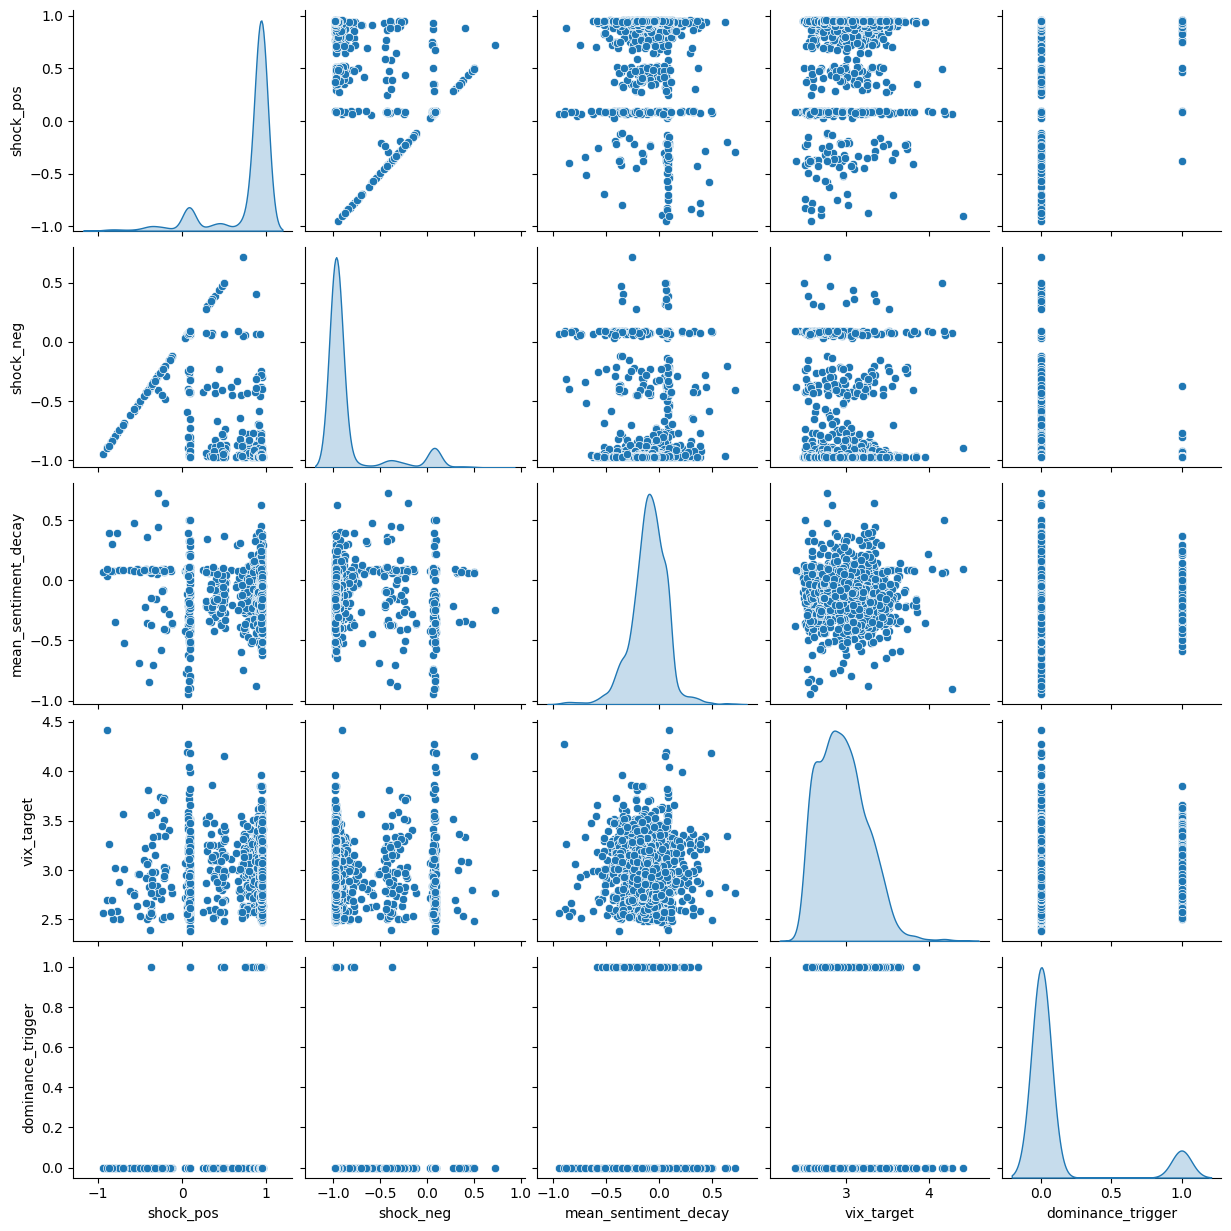

In [757]:
import seaborn as sns
sns.pairplot(df, vars=['shock_pos', 'shock_neg', 'mean_sentiment_decay', 'vix_target', 'dominance_trigger'], diag_kind='kde')


In [758]:
feature_sets = [ #for testing, winner was the first one, decreasing in quality for this model sequentially
    ['shock_neg', 'dominance_trigger'],
    ['shock_neg', 'sentiment_dominance'],
    ['shock_neg', 'sentiment_dominance', 'overall_min'],
    ['shock_pos', 'shock_neg', 'sentiment_dominance', 'overall_min'],
    ['shock_neg', 'mean_sentiment_decay', 'overall_min', 'sentiment_dominance']
]
selected_features = feature_sets[0]

In [759]:
df.index = pd.to_datetime(df['date'])
df.tail()

,date,date.1,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,...,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat
date,,,,,,,,,,,,,,,,,,,,,
2025-04-12,2025-04-12,2025-04-12,-0.089461,-0.957227,0.948515,90,43,-0.008691,-0.941981,0.939109,...,0.426790,0.340215,30.434149,11.581772,0.039359,26.917334,26.917334,29.561233,11.582488,-0.228267
2025-04-13,2025-04-13,2025-04-13,-0.086733,-0.972444,0.952317,74,31,-0.158017,-0.968547,0.952738,...,0.386445,0.313508,30.463558,11.202517,0.038067,27.125000,27.125000,29.404056,11.219157,-0.203140
2025-04-14,2025-04-14,2025-04-14,-0.063972,-0.972737,0.948741,239,123,-0.219557,-0.973235,0.940637,...,0.386445,0.283756,30.491071,10.835645,0.036816,27.429000,27.429000,29.276633,10.862432,-0.170094
2025-04-15,2025-04-15,2025-04-15,-0.174286,-0.975042,0.950775,181,117,-0.138407,-0.974432,0.948124,...,0.351885,0.185777,30.467131,10.480690,-0.033121,27.775000,27.775000,29.179754,10.512887,-0.133622
2025-04-16,2025-04-16,2025-04-16,-0.254442,-0.974785,0.947952,205,169,-0.164961,-0.974998,0.955106,...,0.499311,0.382230,30.607316,10.151497,0.200235,28.095333,28.095333,29.109791,10.171718,-0.099733


In [760]:
df = df.drop(columns=['date', 'date.1'])

In [761]:
df = df.drop(columns=['summary_max', 'summary_pos_count', 'headline_max', 'overall_max', 'shock_pos'])

In [762]:
#df['vix_target_log'] = np.log(df['vix_target'])
#df['vix_target_log_ret'] = df['vix_target_log'].diff().dropna()

# Train: Post-COVID to end of 2023
#train_df = df[(df.index >= "2018-05-01") & (df.index <= "2024-10-15")]
train_df = df[(df.index <= "2024-10-15")]
# Test: Recent years
test_df = df[df.index >= "2024-10-16"]
print(f"Train set: {len(train_df)} rows")
print(f"Test set: {len(test_df)} rows")

df_model = train_df.dropna(subset=feature_sets[4] + ['vix_zscore']).copy() #i chose first set.
X = df_model[feature_sets[0]]
y = df_model['vix_ewm_zscore_flat']


Train set: 1692 rows
Test set: 183 rows


In [763]:
X.isna().sum()
y.isna().sum()

np.int64(0)

In [764]:
train_df.head()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat
date,,,,,,,,,,,,,,,,,,,,,
2018-03-18,-0.806745,-0.806745,1,0.048595,0.048595,1,0,-0.379075,-0.379075,1,...,0.374277,0.653030,16.731070,5.519739,0.414681,14.966207,14.966207,14.384143,5.398441,0.107821
2018-03-30,0.084789,0.084789,0,0.084558,0.084558,1,0,0.084673,0.084673,2,...,0.753526,1.318488,17.239888,5.620198,1.135211,15.101333,15.101333,14.437649,5.194454,0.127768
2018-04-06,0.091514,0.091514,0,0.065591,0.065591,1,0,0.078553,0.078553,2,...,0.241479,0.908250,17.550896,5.525650,0.712876,15.549334,15.549334,14.519759,5.005763,0.205678
2018-04-08,-0.896965,-0.896965,1,0.072943,0.072943,1,0,-0.412011,-0.412011,1,...,-0.416667,0.892227,17.856984,5.435833,0.719856,15.916000,15.916000,14.621931,4.831662,0.267831
2018-04-10,-0.525443,-0.638223,3,0.080863,0.068002,3,0,-0.222290,-0.285111,3,...,-0.200703,0.631611,18.045043,5.280167,0.459258,16.300000,16.300000,14.743671,4.672724,0.333067


In [765]:
test_df_trade = test_df.copy()

In [766]:
test_df.tail()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat
date,,,,,,,,,,,,,,,,,,,,,
2025-04-12,-0.089461,-0.957227,43,-0.008691,-0.941981,105,28,-0.049076,-0.949604,195,...,0.426790,0.340215,30.434149,11.581772,0.039359,26.917334,26.917334,29.561233,11.582488,-0.228267
2025-04-13,-0.086733,-0.972444,31,-0.158017,-0.968547,71,34,-0.122375,-0.970495,145,...,0.386445,0.313508,30.463558,11.202517,0.038067,27.125000,27.125000,29.404056,11.219157,-0.203140
2025-04-14,-0.063972,-0.972737,123,-0.219557,-0.973235,208,154,-0.141765,-0.972986,447,...,0.386445,0.283756,30.491071,10.835645,0.036816,27.429000,27.429000,29.276633,10.862432,-0.170094
2025-04-15,-0.174286,-0.975042,117,-0.138407,-0.974432,195,103,-0.156347,-0.974737,376,...,0.351885,0.185777,30.467131,10.480690,-0.033121,27.775000,27.775000,29.179754,10.512887,-0.133622
2025-04-16,-0.254442,-0.974785,169,-0.164961,-0.974998,247,127,-0.209701,-0.974891,452,...,0.499311,0.382230,30.607316,10.151497,0.200235,28.095333,28.095333,29.109791,10.171718,-0.099733


In [866]:
percentile_markov = 0.4

In [1587]:
transition_matrix, results, df_model = macro_utils.regime_t_markov_model(X, y, df_model, k=2, percentile=percentile_markov)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 16 and the array at index 1 has size 1692

In [768]:
df_model.tail()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat,regime_t_raw,regime_t,regime_t+1,regime_t+1_raw
date,,,,,,,,,,,,,,,,,,,,,
2024-10-11,-0.313376,-0.972448,58,-0.157393,-0.971905,57,48,-0.235385,-0.972176,104,...,0.501729,18.034666,18.034666,18.030169,1.283896,0.003503,0.065116,0,0.0,0.122250
2024-10-12,0.181630,-0.959148,9,0.054226,-0.946041,31,6,0.117928,-0.952595,59,...,0.211239,18.127000,18.127000,18.036416,1.242025,0.072932,0.122250,0,0.0,0.245281
2024-10-13,-0.280690,-0.969393,10,-0.232838,-0.916358,12,8,-0.256764,-0.942875,22,...,0.204007,18.214666,18.214666,18.047916,1.202117,0.138714,0.245281,0,1.0,0.495994
2024-10-14,0.009047,-0.974299,24,-0.044218,-0.972195,43,20,-0.017585,-0.973247,82,...,0.197043,18.319333,18.319333,18.065427,1.164669,0.218007,0.495994,1,1.0,0.787314
2024-10-15,-0.242439,-0.975493,63,-0.210137,-0.972273,74,56,-0.226288,-0.973883,141,...,0.556791,18.404667,18.404667,18.087313,1.129657,0.280929,0.787314,1,NaN,NaN


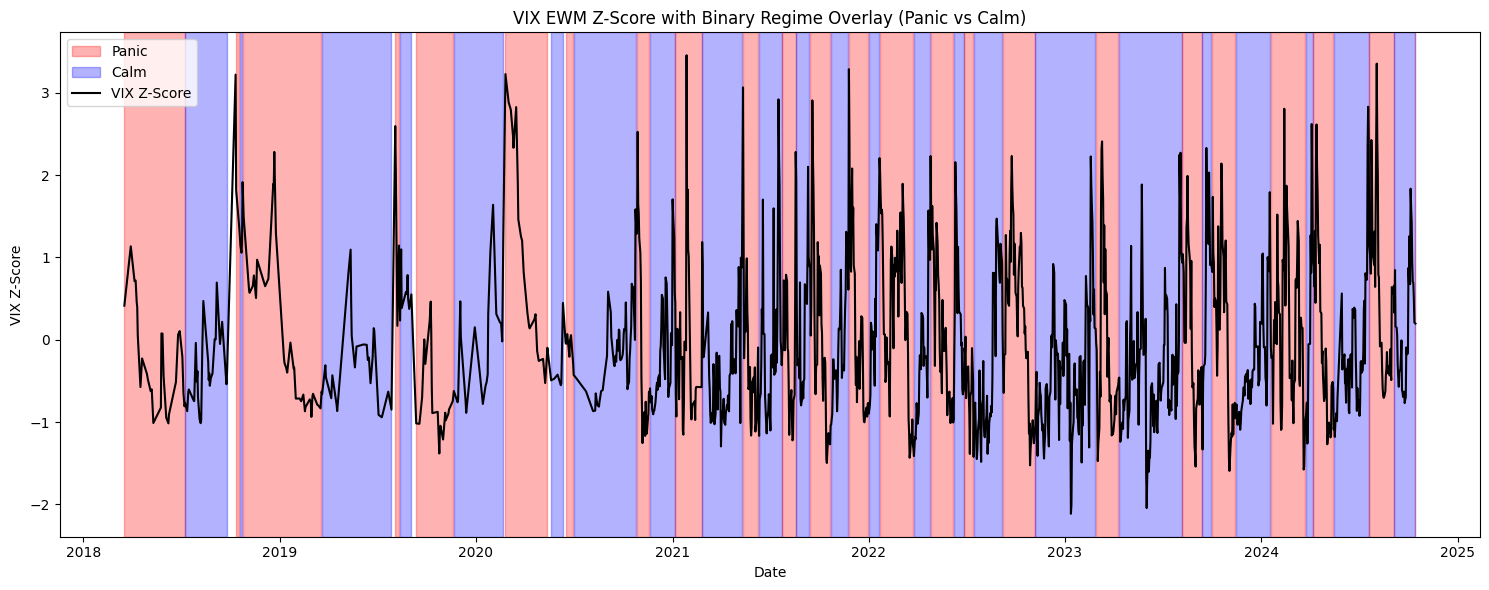

In [1150]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(15, 6))
plt.plot(df_model.index, df_model['vix_ewm_zscore'], label='VIX_t (EWM Z-Score)', color='black')

# Efficient binary shading
start_idx = None
current_regime = None

for i in range(len(df_model)):
    regime = df_model['regime_t'].iloc[i]
    
    if regime != current_regime:
        if current_regime is not None:
            # Draw previous span
            plt.axvspan(df_model.index[start_idx], df_model.index[i - 1],
                        color='red' if current_regime == 1 else 'blue', alpha=0.3)
        # Start new span
        start_idx = i
        current_regime = regime

# Draw last span
if current_regime is not None:
    plt.axvspan(df_model.index[start_idx], df_model.index[-1],
                color='red' if current_regime == 1 else 'blue', alpha=0.3)

# Legend and labels
panic_patch = mpatches.Patch(color='red', alpha=0.3, label='Panic')
calm_patch = mpatches.Patch(color='blue', alpha=0.3, label='Calm')
plt.legend(handles=[panic_patch, calm_patch, plt.Line2D([], [], color='black', label='VIX Z-Score')])

plt.title('VIX EWM Z-Score with Binary Regime Overlay (Panic vs Calm)')
plt.xlabel('Date')
plt.ylabel('VIX Z-Score')
plt.tight_layout()
plt.show()


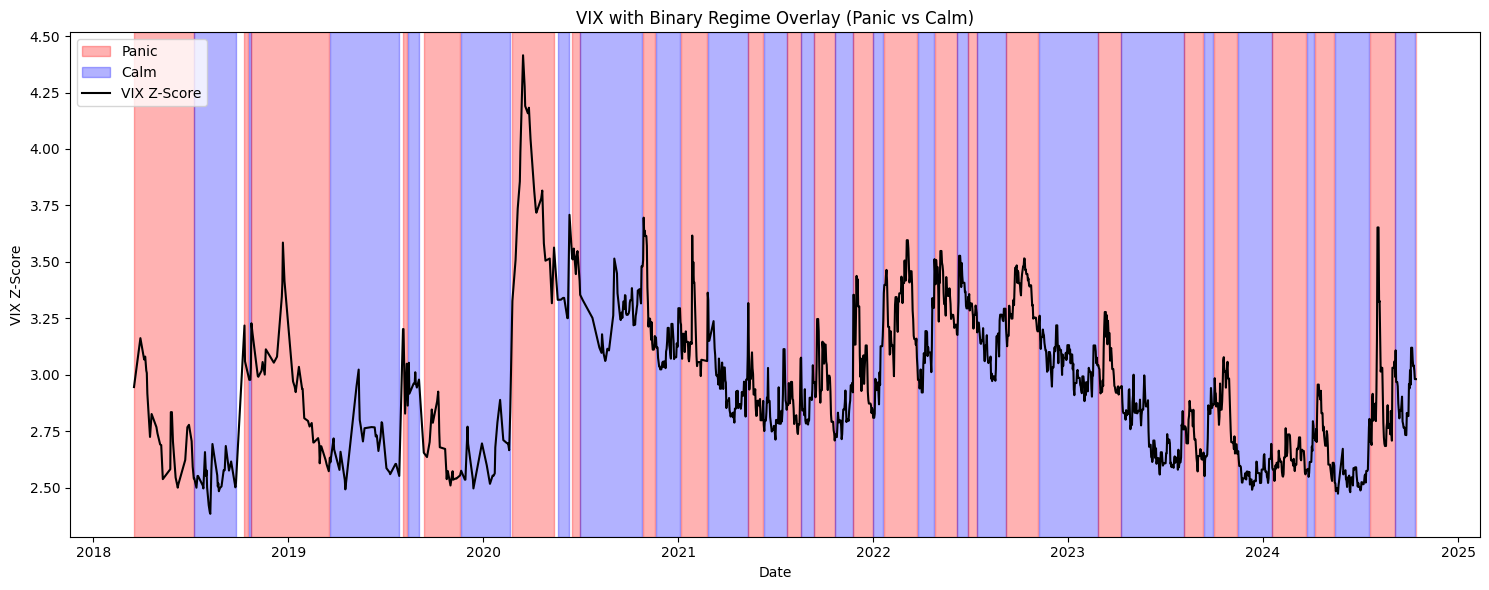

In [1151]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(15, 6))
plt.plot(df_model.index, df_model['vix_target'], label='VIX_t', color='black')

# Efficient binary shading
start_idx = None
current_regime = None

for i in range(len(df_model)):
    regime = df_model['regime_t'].iloc[i]
    
    if regime != current_regime:
        if current_regime is not None:
            # Draw previous span
            plt.axvspan(df_model.index[start_idx], df_model.index[i - 1],
                        color='red' if current_regime == 1 else 'blue', alpha=0.3)
        # Start new span
        start_idx = i
        current_regime = regime

# Draw last span
if current_regime is not None:
    plt.axvspan(df_model.index[start_idx], df_model.index[-1],
                color='red' if current_regime == 1 else 'blue', alpha=0.3)

# Legend and labels
panic_patch = mpatches.Patch(color='red', alpha=0.3, label='Panic')
calm_patch = mpatches.Patch(color='blue', alpha=0.3, label='Calm')
plt.legend(handles=[panic_patch, calm_patch, plt.Line2D([], [], color='black', label='VIX Z-Score')])

plt.title('VIX with Binary Regime Overlay (Panic vs Calm)')
plt.xlabel('Date')
plt.ylabel('VIX Z-Score')
plt.tight_layout()
plt.show()


In [1152]:
df_model.tail()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_ewm_zscore_flat,regime_t_raw,regime_t,regime_t+1,regime_t+1_raw,panic_prob,regime_group,is_sustained_regime1,regime_t-1,is_transition
date,,,,,,,,,,,,,,,,,,,,,
2024-10-10,-0.008239,-0.976220,42,-0.162519,-0.972208,66,47,-0.085379,-0.974214,137,...,-0.042834,0.050976,0,0.0,0.065116,0.438433,46,False,0.0,False
2024-10-11,-0.313376,-0.972448,58,-0.157393,-0.971905,57,48,-0.235385,-0.972176,104,...,0.003503,0.065116,0,0.0,0.122250,0.252721,46,False,0.0,False
2024-10-12,0.181630,-0.959148,9,0.054226,-0.946041,31,6,0.117928,-0.952595,59,...,0.072932,0.122250,0,0.0,0.245281,0.438369,46,False,0.0,False
2024-10-13,-0.280690,-0.969393,10,-0.232838,-0.916358,12,8,-0.256764,-0.942875,22,...,0.138714,0.245281,0,1.0,0.495994,0.458514,46,False,0.0,False
2024-10-14,0.009047,-0.974299,24,-0.044218,-0.972195,43,20,-0.017585,-0.973247,82,...,0.218007,0.495994,1,1.0,0.787314,0.456884,47,True,0.0,True


In [1153]:
df_model = df_model.dropna()

In [1154]:
clf, y_pred, classification_df = macro_utils.clf_panic_tomorrow(df_model, selected_features, 'regime_t+1')

              precision    recall  f1-score   support

         0.0       0.62      0.96      0.75       922
         1.0       0.85      0.29      0.44       768

    accuracy                           0.65      1690
   macro avg       0.73      0.62      0.59      1690
weighted avg       0.72      0.65      0.61      1690



/Users/dsuniaga/Documents/GitHub/VIXNLP/finnhub_news/macro_utils.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['panic_prob'] = probs


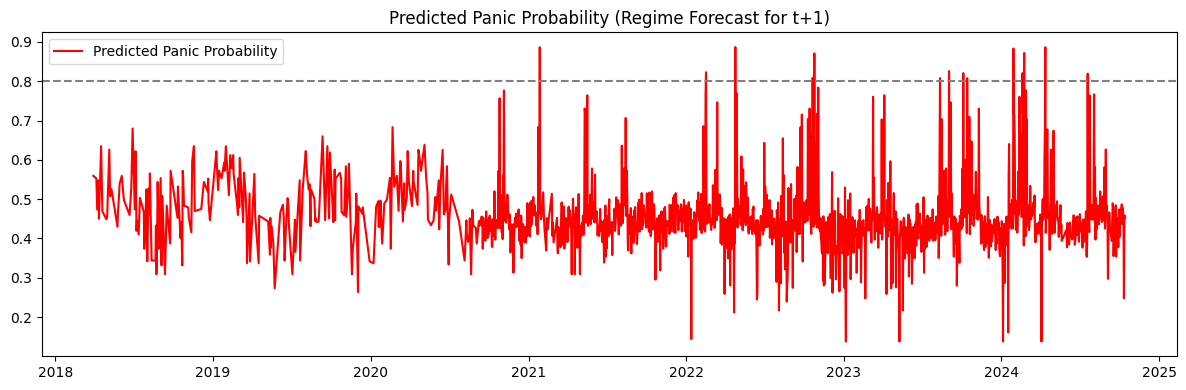

In [1155]:
plt.figure(figsize=(12, 4))
plt.plot(df_model.index, df_model['panic_prob'], label='Predicted Panic Probability', color='red')
plt.axhline(0.8, linestyle='--', color='gray')
plt.title("Predicted Panic Probability (Regime Forecast for t+1)")
plt.legend()
plt.tight_layout()
plt.show()


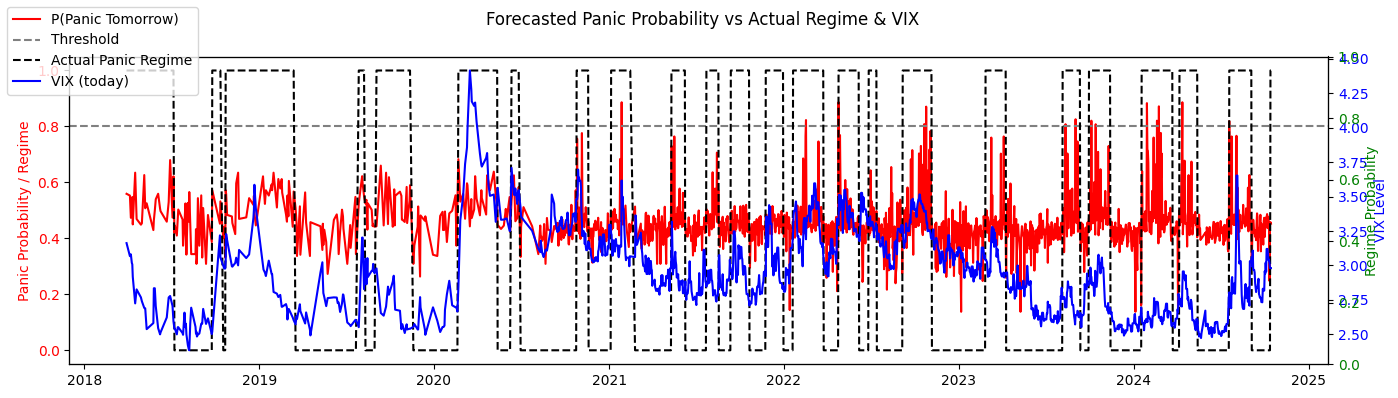

In [1156]:
fig, ax1 = plt.subplots(figsize=(14, 4)) #GOLD. panic regime probability goes up before vix even spikes. probability of panic tomorrow from classifier is high.

# Panic probability
ax1.plot(classification_df.index, classification_df['panic_prob'], label='P(Panic Tomorrow)', color='red')
ax1.axhline(0.8, linestyle='--', color='gray', label='Threshold')
ax1.plot(classification_df.index, classification_df['regime_t+1'], linestyle='--', color='black', label='Actual Panic Regime')
ax1.set_ylabel("Panic Probability / Regime", color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Add second y-axis for VIX
ax2 = ax1.twinx()
ax2.plot(classification_df.index, classification_df['vix_target'], label='VIX (today)', color='blue')
ax2.set_ylabel("VIX Level", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax3 = ax1.twinx()
#ax3.plot(classification_df.index, classification_df['regime_t_raw'], label='Regime Probability', color='green')
ax3.set_ylabel("Regime Probability", color='green')
ax3.tick_params(axis='y', labelcolor='green')

fig.suptitle("Forecasted Panic Probability vs Actual Regime & VIX")
fig.tight_layout()
fig.legend(loc='upper left')
plt.show()
import matplotlib.dates as mdates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()


for each regime=1, we now get the set of days aferwards to see how vix behaves as soon as the model changes regime

In [1157]:

classification_df = macro_utils.identify_sustained_regimes_and_transitions(classification_df)

In [1158]:
classification_df['is_transition'].value_counts()

is_transition
False    1667
True       23
Name: count, dtype: int64

In [1159]:
classification_df['regime_t']

date
2018-03-30    1
2018-04-06    1
2018-04-08    1
2018-04-10    1
2018-04-11    1
             ..
2024-10-10    0
2024-10-11    0
2024-10-12    0
2024-10-13    0
2024-10-14    1
Name: regime_t, Length: 1690, dtype: int64

In [1160]:

# Usage Example:
result = macro_utils.transform_vix_data(classification_df, window=60, k=2)
vix_windows_df_train = result["vix_windows_df_train"]
regime_windows_df_train = result["regime_windows_df_train"]
vix_windows_past_df_train = result["vix_windows_past_df_train"]


In [1161]:
regime_windows_df_train.shape

(21, 60)

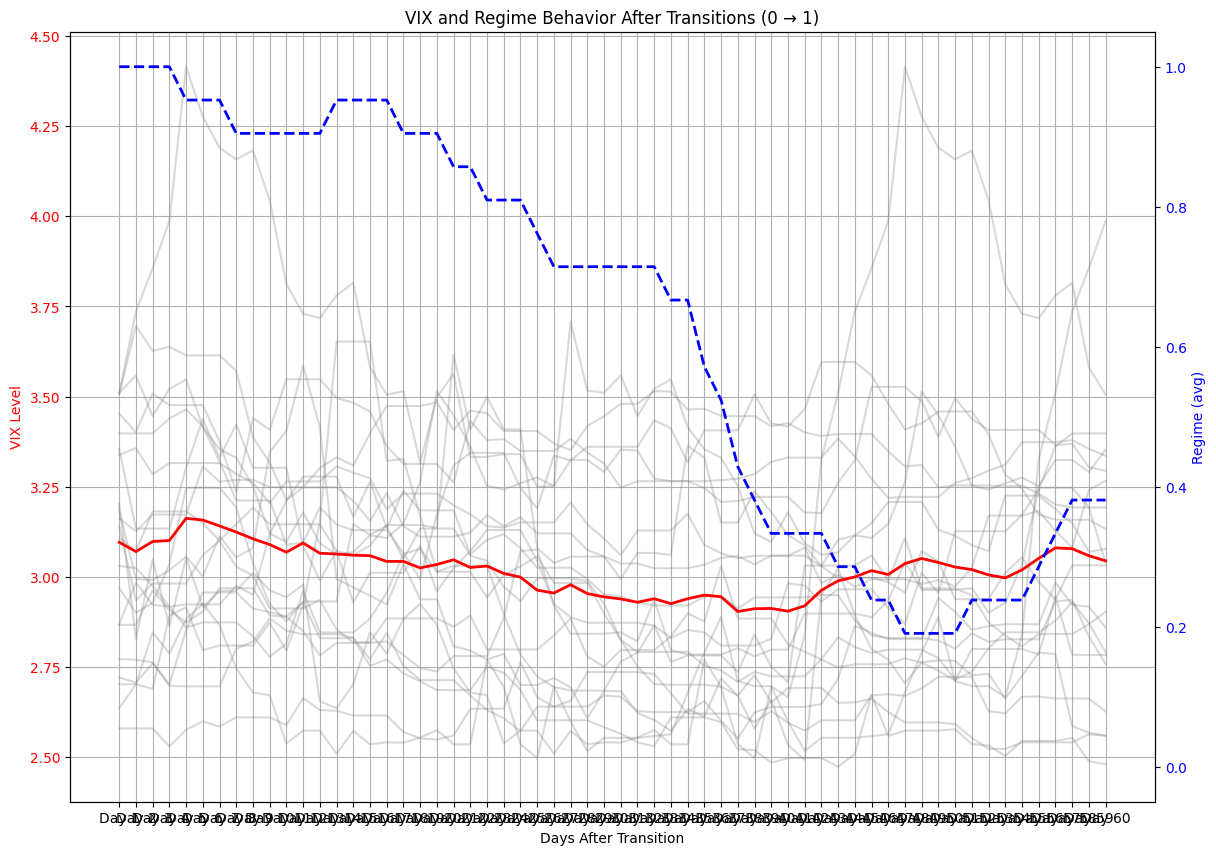

In [1162]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

# Primary axis: VIX transitions
ax1 = plt.gca()
ax1.plot(vix_windows_df_train.T, color="gray", alpha=0.3, label="Individual VIX transitions")
ax1.plot(vix_windows_df_train.mean(axis=0).values, color="red", linewidth=2, label="Mean VIX path")
ax1.set_xlabel("Days After Transition")
ax1.set_ylabel("VIX Level", color="red")
ax1.tick_params(axis='y', labelcolor="red")
ax1.set_title("VIX and Regime Behavior After Transitions (0 → 1)")
ax1.grid(True)

# Secondary axis: Regime values
ax2 = ax1.twinx()
ax2.plot(regime_windows_df_train.mean(axis=0).values, color="blue", linewidth=2, linestyle="--", label="Mean Regime level")
ax2.set_ylabel("Regime (avg)", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")
ax2.set_ylim(-0.05, 1.05)  # Because regime is binary

# Combined legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
#plt.tight_layout()
plt.show()



since some spikes happen quite some time after the regime switches, we will build a classifier for 0 (immediate) or 1 (delayed), then feed this into a model for vix level forecasting

In [1163]:
vix_windows_past_df_train.tail()

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 51,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60
transition_time,,,,,,,,,,,,,,,,,,,,,
2023-08-07,2.636196,2.634762,2.613739,2.626840,2.708717,2.708717,2.708717,2.681706,2.630449,2.674149,...,2.590017,2.612273,2.612273,2.612273,2.634045,2.778198,2.767576,2.839078,2.758109,2.758109
2023-10-01,2.778198,2.767576,2.839078,2.758109,2.758109,2.758109,2.771964,2.770086,2.763170,2.697326,...,2.864484,2.844909,2.827314,2.827314,2.827314,2.941276,2.902520,2.853016,2.863343,2.868467
2024-01-19,2.596001,2.591516,2.553344,2.522524,2.522524,2.540814,2.540814,2.540814,2.540814,2.563410,...,2.546315,2.540814,2.520917,2.541602,2.627563,2.627563,2.627563,2.627563,2.693951,2.648300
2024-04-07,2.551786,2.548664,2.559550,2.634045,2.634045,2.634045,2.763170,2.665838,2.639771,2.656055,...,2.565718,2.613739,2.613739,2.613739,2.613739,2.681706,2.662355,2.794228,2.774462,2.720637
2024-07-20,2.596746,2.521721,2.519308,2.484073,2.497329,2.497329,2.497329,2.473171,2.508786,2.672078,...,2.553344,2.558777,2.522524,2.574138,2.574138,2.574138,2.579459,2.672768,2.768204,2.804572


In [1164]:
vix_windows_df_train.iloc[-1].max()

np.float64(3.6524747643078785)

In [1165]:
df_delayed_spike_prob, clf_delayed_spike_prob, vix_pct_change_lookback_df_train = macro_utils.clf_delayed_spike_prob(vix_windows_df_train, df_model, "vix_target")

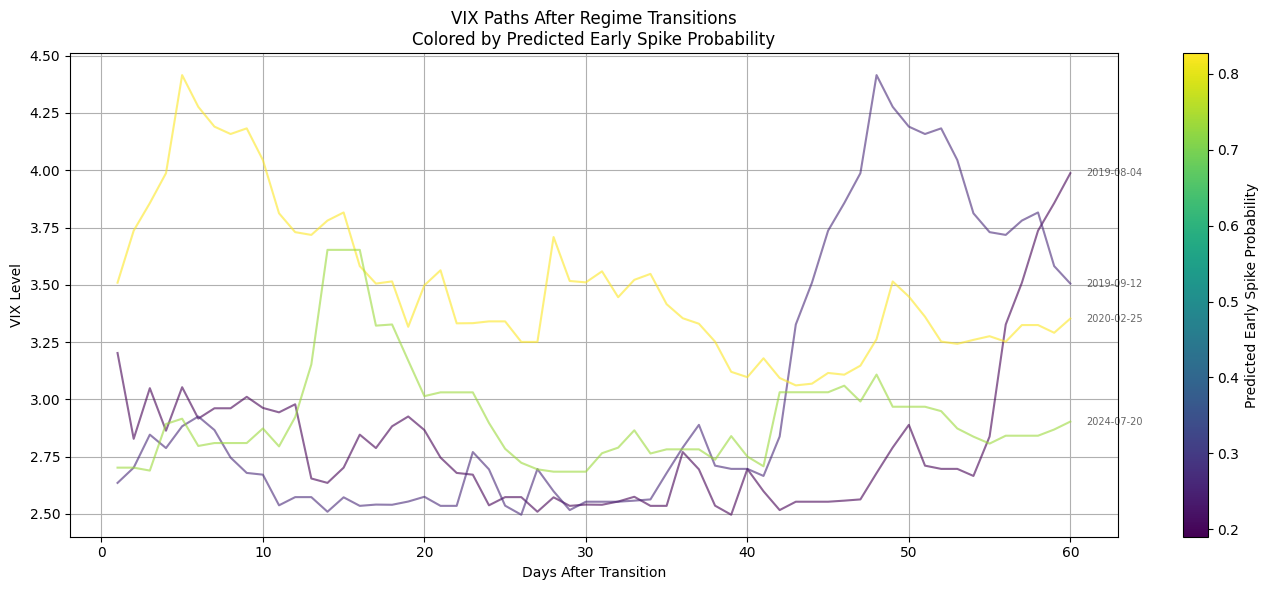

In [1166]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Filter rows with predictions
df_plot = df_delayed_spike_prob.dropna(subset=["early_spike_prob"])

# Normalize probs for coloring
probs = df_plot["early_spike_prob"]
colors = cm.viridis((probs - probs.min()) / (probs.max() - probs.min()))

fig, ax = plt.subplots(figsize=(14, 6))

# Plot VIX paths, colored by classifier probability
for i, (date, row) in enumerate(df_plot.iterrows()):
    vix_path = row.iloc[:60]  # assumes 60-day VIX columns are first
    ax.plot(range(1, 61), vix_path.values, color=colors[i], alpha=0.6)
    ax.text(61, vix_path.values[-1], date.strftime("%Y-%m-%d"), fontsize=7, alpha=0.6, va="center")

# Add colorbar
sm = ScalarMappable(cmap="viridis", norm=Normalize(vmin=probs.min(), vmax=probs.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Predicted Early Spike Probability")

# Labels and layout
ax.set_title("VIX Paths After Regime Transitions\nColored by Predicted Early Spike Probability")
ax.set_xlabel("Days After Transition")
ax.set_ylabel("VIX Level")
ax.grid(True)
plt.tight_layout()
plt.show()



In [1167]:
classification_df['regime_t'].value_counts()

regime_t
0    922
1    768
Name: count, dtype: int64

We will now predict whether the regime switch is a spike or not

because of randomness, we will just predict peak, half decay time, and rising time.

In [1168]:
# =============================================================
# 0)  PREP  –  make sure the raw news DataFrame is date‑indexed
# =============================================================
news = train_df.copy()                       # original df you posted   # string/ts column → index
news = news.sort_index()                     # chronological order

# =============================================================
# 1)  ENGINEER EXTRA NEWS FEATURES (text‑only)
# =============================================================
def engineer_news_feats(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()


    # --- positive / negative ratios and range (max‑min) ---
    for prefix in ['summary', 'headline', 'overall']:
        neg = f'{prefix}_neg_count'
        tot = f'{prefix}_tot_count'

    # --- one‑hot encode sentiment dominance flag -------------
    dom_dummies = pd.get_dummies(out['dominance_trigger'], prefix='dom')
    out = pd.concat([out, dom_dummies], axis=1)

    # OPTIONAL: drop the raw *_tot_count columns
    out = out.drop(columns=[c for c in out.columns if c.endswith('_tot_count')])
    return out

news_feats = engineer_news_feats(news)

# =============================================================
# 2)  DENSE DAILY INDEX  (forward‑fill missing dates)
# =============================================================
news_feats.index = pd.to_datetime(news_feats.index).normalize()        # 00:00:00
dense_idx = pd.date_range(news_feats.index.min(),
                          news_feats.index.max(),
                          freq='D')

news_dense = (
    news_feats
      .reindex(dense_idx)      # insert weekends / holidays
      .ffill()                 # carry last known sentiment forward
)



/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_72581/37269508.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .ffill()                 # carry last known sentiment forward


In [1169]:
train_df.head()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat
date,,,,,,,,,,,,,,,,,,,,,
2018-03-18,-0.806745,-0.806745,1,0.048595,0.048595,1,0,-0.379075,-0.379075,1,...,0.374277,0.653030,16.731070,5.519739,0.414681,14.966207,14.966207,14.384143,5.398441,0.107821
2018-03-30,0.084789,0.084789,0,0.084558,0.084558,1,0,0.084673,0.084673,2,...,0.753526,1.318488,17.239888,5.620198,1.135211,15.101333,15.101333,14.437649,5.194454,0.127768
2018-04-06,0.091514,0.091514,0,0.065591,0.065591,1,0,0.078553,0.078553,2,...,0.241479,0.908250,17.550896,5.525650,0.712876,15.549334,15.549334,14.519759,5.005763,0.205678
2018-04-08,-0.896965,-0.896965,1,0.072943,0.072943,1,0,-0.412011,-0.412011,1,...,-0.416667,0.892227,17.856984,5.435833,0.719856,15.916000,15.916000,14.621931,4.831662,0.267831
2018-04-10,-0.525443,-0.638223,3,0.080863,0.068002,3,0,-0.222290,-0.285111,3,...,-0.200703,0.631611,18.045043,5.280167,0.459258,16.300000,16.300000,14.743671,4.672724,0.333067


In [1170]:
# ------------------------------------------------------------
# 3)  BUILD ARC-LEVEL TABLE  (robust to missing news dates + look-back stats)
# ------------------------------------------------------------
records = []
lookback_days = [2, 5, 7]
lookback_feats = [
    "shock_neg",
    "vix_zscore",
    "vix_target",
    "sentiment_dominance",

]

for dt, row in vix_windows_df_train.iterrows():
    # --- detect arc in the 60-day window ---
    v = row[[f"Day {i}" for i in range(1, 61)]].values
    r = regime_windows_df_train.loc[dt, [f"Day {i}" for i in range(1, 61)]].values
    start_idx, peak_idx = macro_utils.detect_spike_arc_within_regime(v, r)
    start_val, peak_val = v[start_idx], v[peak_idx]
    rise_dur = peak_idx - start_idx
    decay_idx = np.argmax(v[peak_idx:] < 0.5 * peak_val)
    half_life = decay_idx if decay_idx > 0 else len(v) - peak_idx

    dt_norm = pd.to_datetime(dt).normalize()

    # -------- safe fetch of nearest-past news features --------
    try:
        feats_on_start = news_dense.loc[:dt_norm].iloc[-1].to_dict()
    except IndexError:
        # no prior news available – skip this arc
        continue

    # -------- compute look-back statistics from classification_df --------
    lookback_stats = {}
    for w in lookback_days:
        start_date = dt_norm - pd.Timedelta(days=w)
        window_df = classification_df.loc[start_date:dt_norm]

        for feat in lookback_feats:
            col_mean = window_df[feat].mean()
            col_std = window_df[feat].std()
            # percent change over the window: (last−first) / first
            if len(window_df) > 1 and window_df[feat].iloc[0] != 0:
                col_pct = (window_df[feat].iloc[-1] - window_df[feat].iloc[0]) / window_df[feat].iloc[0]
            else:
                col_pct = np.nan

            lookback_stats[f"{feat}_mean_{w}d"] = col_mean
            lookback_stats[f"{feat}_std_{w}d"]  = col_std
            lookback_stats[f"{feat}_pctchg_{w}d"] = col_pct

    # --- aggregate everything into one record ---
    records.append({
        "date_start":    dt_norm,
        "peak_vix":      peak_val,
        "vix0":          start_val,
        "T_up":          rise_dur,
        "T_half":        half_life,
        **feats_on_start,
        **lookback_stats,
    })

arc_df = (
    pd.DataFrame(records)
      .set_index("date_start")
      .astype(float, errors="ignore")
)

print("arc_df shape:", arc_df.shape)

arc_df shape: (21, 68)


In [1171]:
arc_df['early_spike_prob'] = vix_windows_df_train['early_spike_prob'].fillna(0.5)

In [1172]:
arc_df = arc_df.dropna()

In [1173]:
arc_df = arc_df.drop(columns=['vix_target'])

In [1174]:
len(arc_df)

16

In [1958]:
# ============================================================
# 0)  CONFIG & IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer, mean_absolute_error

target_cols   = ["peak_vix", "T_up", "T_half"]
feature_cols  = arc_df.columns.difference(target_cols)

mlp_params = dict(
    hidden_layer_sizes=(8,4),
    activation="tanh",
    solver="adam",
    learning_rate_init=1e-2,   # ↑ a bit
    alpha=2,                # much weaker L2
    max_iter=2000,
    batch_size=2,
    early_stopping=True, 
    validation_fraction=0.2,
    n_iter_no_change=100,
    random_state=38,
)

# ============================================================
# 1)  INPUT MATRICES & CV SPLIT
# ============================================================
X_full = arc_df[feature_cols].values
y_full = arc_df[target_cols].values
tscv   = TimeSeriesSplit(n_splits=10)

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# ============================================================
# 2)  TRAIN PER‑TARGET WITH y‑SCALING
# ============================================================
models, cv_mae = {}, {}

for i, col in enumerate(target_cols):
    y = y_full[:, i]

    # pipeline: X‑scaler → MLP, plus y‑scaler wrapper
    base_pipe = Pipeline([
        ("scale_X", StandardScaler()),
        ("mlp",     MLPRegressor(**mlp_params)),
    ])
    qt = QuantileTransformer(n_quantiles=59, output_distribution='normal', random_state=38)
    pipe = TransformedTargetRegressor(
        regressor=base_pipe,
        transformer=qt     # scales y
    )

    # walk‑forward CV
    cv = cross_validate(pipe, X_full, y,
                        cv=tscv,
                        scoring=mae_scorer,
                        n_jobs=-1,
                        return_train_score=False)
    cv_mae[col] = -cv["test_score"].mean()
    print(f"{col:8s} | MAE (5-fold): {cv_mae[col]:.3f}")

    # fit on all data & save
    pipe.fit(X_full, y)
    models[col] = pipe
    joblib.dump(pipe, f"mlp_{col}.pkl")

print("\nSaved pickled models:", [f"mlp_{c}.pkl" for c in target_cols])

# ============================================================
# 3)  HELPER FOR NEW PREDICTIONS
# ============================================================
def predict_new_arc(row_df: pd.DataFrame):
    """
    row_df: DataFrame with one row and the same feature columns.
    returns dict {target: prediction}
    """
    preds = {col: float(models[col].predict(row_df[feature_cols].values))
             for col in target_cols}
    return preds

# Example:
# new_row = arc_df.iloc[[-1]]
# print(predict_new_arc(new_row))


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (59) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (59) is greater than the total number of samples (7). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (59) is greater than the total number of samples (8). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (59) is greater than the total number of samples (9). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIX

peak_vix | MAE (5-fold): 0.227


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (59) is greater than the total number of samples (16). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (59) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (59) is greater than the total number of samples (7). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (59) is greater than the total number of samples (8). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VI

T_up     | MAE (5-fold): 14.659


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (59) is greater than the total number of samples (16). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (59) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (59) is greater than the total number of samples (7). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (59) is greater than the total number of samples (8). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VI

T_half   | MAE (5-fold): 15.212

Saved pickled models: ['mlp_peak_vix.pkl', 'mlp_T_up.pkl', 'mlp_T_half.pkl']


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (59) is greater than the total number of samples (16). n_quantiles is set to n_samples.
  warnings.warn(


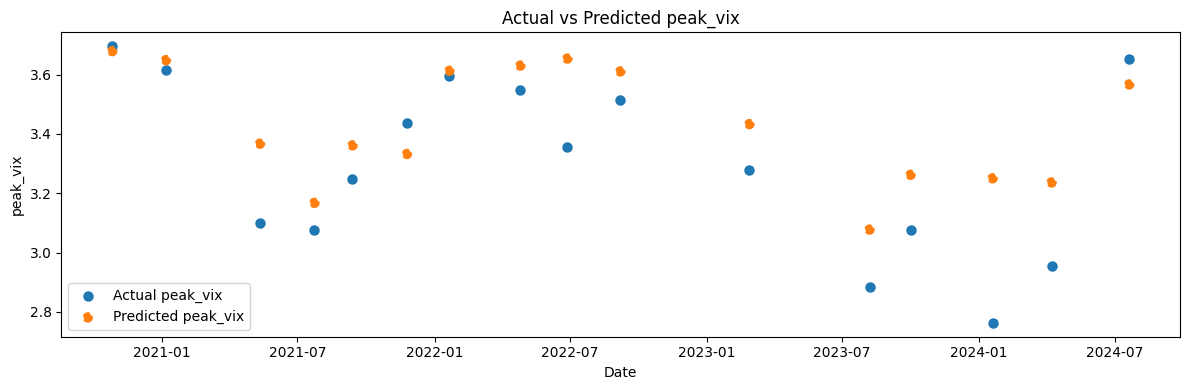

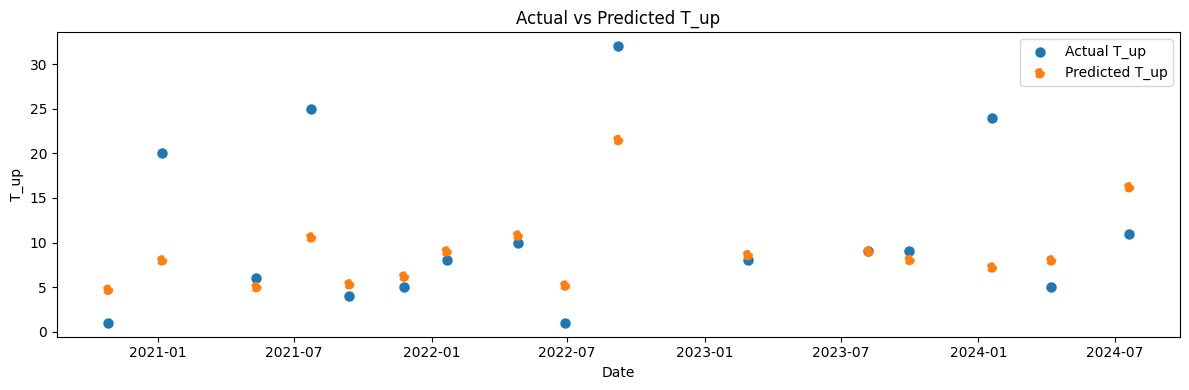

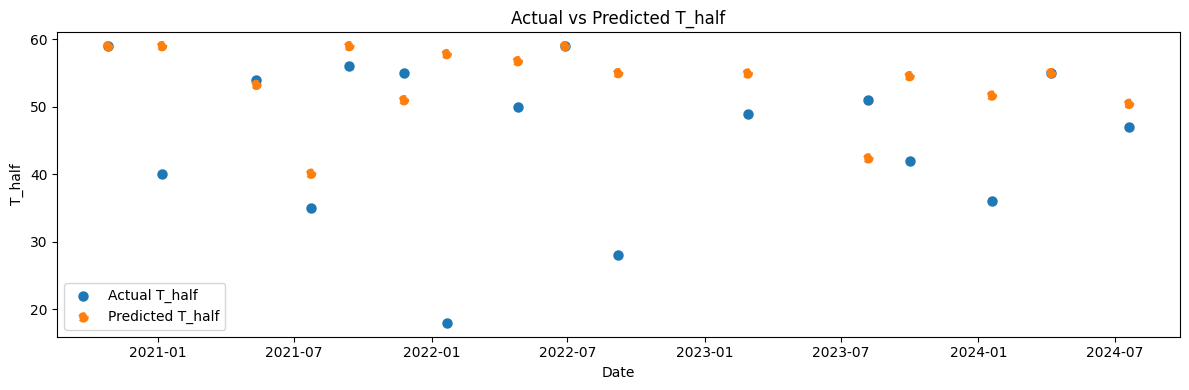

In [1959]:
import joblib, matplotlib.pyplot as plt

feature_cols = arc_df.columns.difference(["peak_vix", "T_up", "T_half"])
X_full       = arc_df[feature_cols].values
dates        = arc_df.index         # x‑axis

models = {
    "peak_vix": joblib.load("mlp_peak_vix.pkl"),
    "T_up":     joblib.load("mlp_T_up.pkl"),
    "T_half":   joblib.load("mlp_T_half.pkl"),
}

for target, model in models.items():
    y_true = arc_df[target].values
    y_pred = model.predict(X_full)

    plt.figure(figsize=(12, 4))
    plt.scatter(dates, y_true, label=f"Actual {target}", linewidth=1.5)
    plt.scatter(dates, y_pred, label=f"Predicted {target}", linestyle="--", linewidth=1.5)
    plt.title(f"Actual vs Predicted {target}")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend()
    plt.tight_layout()
    plt.show()

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


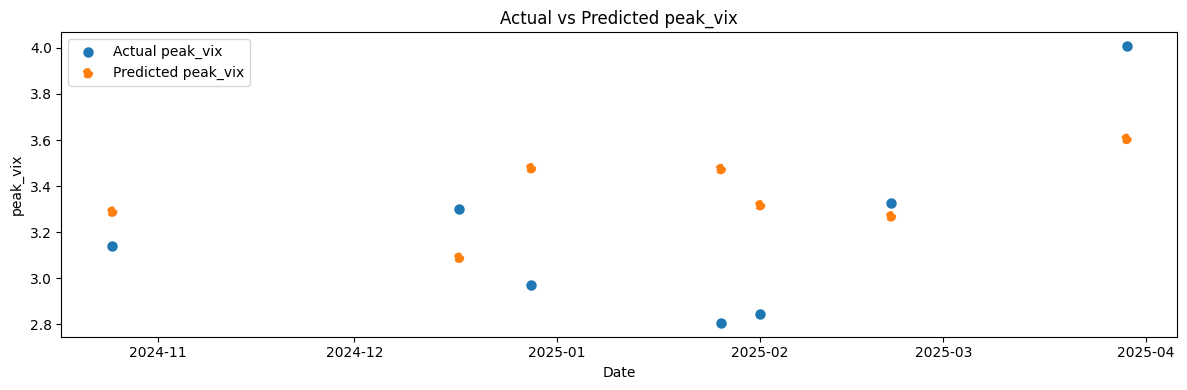

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


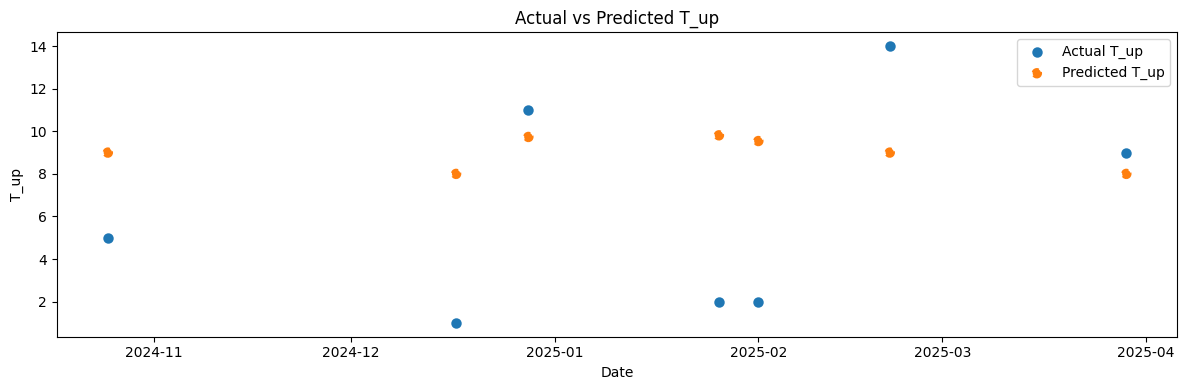

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


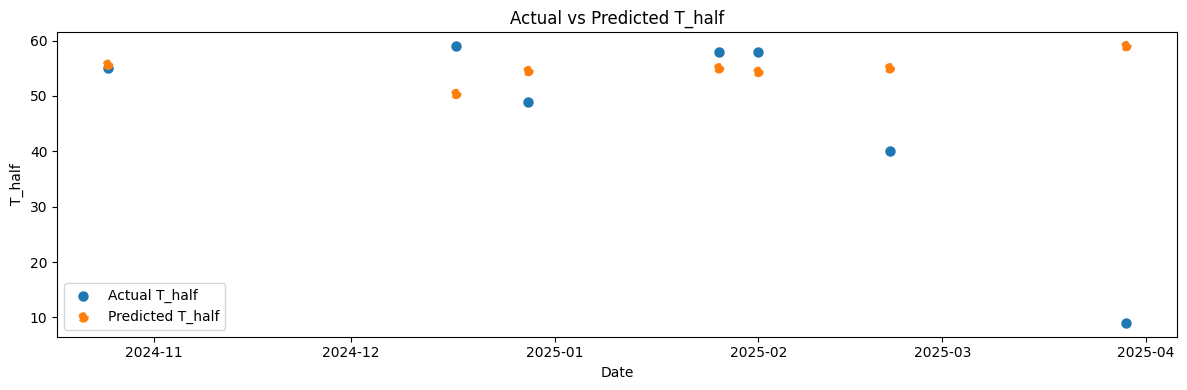

In [1960]:
import joblib, matplotlib.pyplot as plt

feature_cols = arc_df.columns.difference(["peak_vix", "T_up", "T_half"])

X_full_test = arc_df_test.reindex(columns=feature_cols)
X_full_test = X_full_test.fillna(0)

dates = arc_df_test.index         # x‑axis

models = {
    "peak_vix": joblib.load("mlp_peak_vix.pkl"),
    "T_up":     joblib.load("mlp_T_up.pkl"),
    "T_half":   joblib.load("mlp_T_half.pkl"),
}

for target, model in models.items():
    y_true_test = arc_df_test[target].values
    y_pred_test = model.predict(X_full_test)

    plt.figure(figsize=(12, 4))
    plt.scatter(dates, y_true_test, label=f"Actual {target}", linewidth=1.5)
    plt.scatter(dates, y_pred_test, label=f"Predicted {target}", linestyle="--", linewidth=1.5)
    plt.title(f"Actual vs Predicted {target}")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend()
    plt.tight_layout()
    plt.show()


# XGBoost

In [2033]:
# ============================================================
# 0)  CONFIG & IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_pinball_loss
from xgboost import XGBRegressor

# Define targets and features
target_cols   = ["peak_vix", "T_up", "T_half"]
feature_cols  = arc_df.columns.difference(target_cols)

# Quantile levels to train
quantiles = [0.1, 0.5, 0.9]

# Base model parameters (shared)
base_xgb_params = {
    "n_estimators": 100,
    "max_depth": 5,
    "learning_rate": 0.07,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "reg_alpha": 0.1,
    "reg_lambda": 1.0,
    "random_state": 42,
    "gamma": 0.05,
}

# Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=10)

# Store all models by target and quantile
models = {}
cv_mae = {}

# ============================================================
# 1)  TRAIN EACH TARGET AT EACH QUANTILE LEVEL
# ============================================================
X_full = arc_df[feature_cols].values
y_full = arc_df[target_cols].values

for i, col in enumerate(target_cols):
    y = y_full[:, i]

    for q in quantiles:
        print(f"\nTraining {col} at quantile {q:.1f}...")

        # Update XGBoost parameters
        xgb_params = base_xgb_params.copy()
        xgb_params.update({
            "objective": "reg:quantileerror",
            "quantile_alpha": q,
        })

        # Scorer for this quantile
        pinball_scorer = make_scorer(
            mean_pinball_loss,
            greater_is_better=False,
            alpha=q
        )

        # Build pipeline (no y-scaling)
        pipe = Pipeline([
            ("scale_X", StandardScaler()),
            ("xgb",     XGBRegressor(**xgb_params)),
        ])

        # Cross-validation
        cv = cross_validate(
            pipe, X_full, y,
            cv=tscv,
            scoring=pinball_scorer,
            n_jobs=-1,
            return_train_score=False
        )

        avg_score = -cv["test_score"].mean()
        cv_mae[(col, q)] = avg_score
        print(f"{col:8s} | q={q:.1f} | Pinball loss (CV): {avg_score:.3f}")

        # Fit and save model
        pipe.fit(X_full, y)
        model_key = (col, q)
        models[model_key] = pipe
        joblib.dump(pipe, f"xgb_{col}_q{q:.1f}.pkl")

print("\nSaved pickled models:")
print([f"xgb_{col}_q{q:.1f}.pkl" for col in target_cols for q in quantiles])

# ============================================================
# 2)  PREDICT FUNCTION WITH SPREAD
# ============================================================
def predict_new_arc(row_df: pd.DataFrame):
    """
    row_df: DataFrame with one row and the same feature columns.
    Returns a nested dict: {target: {q: pred}}
    """
    preds = {}

    for col in target_cols:
        preds[col] = {}
        for q in quantiles:
            model = models[(col, q)]
            pred = float(model.predict(row_df[feature_cols].values))
            preds[col][q] = pred

        # Optional: Add spread
        preds[col]["spread"] = preds[col][0.9] - preds[col][0.1]

    return preds

# Example usage:
# new_row = arc_df.iloc[[-1]]
# print(predict_new_arc(new_row))



Training peak_vix at quantile 0.1...
peak_vix | q=0.1 | Pinball loss (CV): 0.065

Training peak_vix at quantile 0.5...
peak_vix | q=0.5 | Pinball loss (CV): 0.098

Training peak_vix at quantile 0.9...


peak_vix | q=0.9 | Pinball loss (CV): 0.043

Training T_up at quantile 0.1...
T_up     | q=0.1 | Pinball loss (CV): 0.924

Training T_up at quantile 0.5...
T_up     | q=0.5 | Pinball loss (CV): 3.730

Training T_up at quantile 0.9...
T_up     | q=0.9 | Pinball loss (CV): 2.505

Training T_half at quantile 0.1...
T_half   | q=0.1 | Pinball loss (CV): 3.825

Training T_half at quantile 0.5...
T_half   | q=0.5 | Pinball loss (CV): 6.851

Training T_half at quantile 0.9...
T_half   | q=0.9 | Pinball loss (CV): 1.464

Saved pickled models:
['xgb_peak_vix_q0.1.pkl', 'xgb_peak_vix_q0.5.pkl', 'xgb_peak_vix_q0.9.pkl', 'xgb_T_up_q0.1.pkl', 'xgb_T_up_q0.5.pkl', 'xgb_T_up_q0.9.pkl', 'xgb_T_half_q0.1.pkl', 'xgb_T_half_q0.5.pkl', 'xgb_T_half_q0.9.pkl']


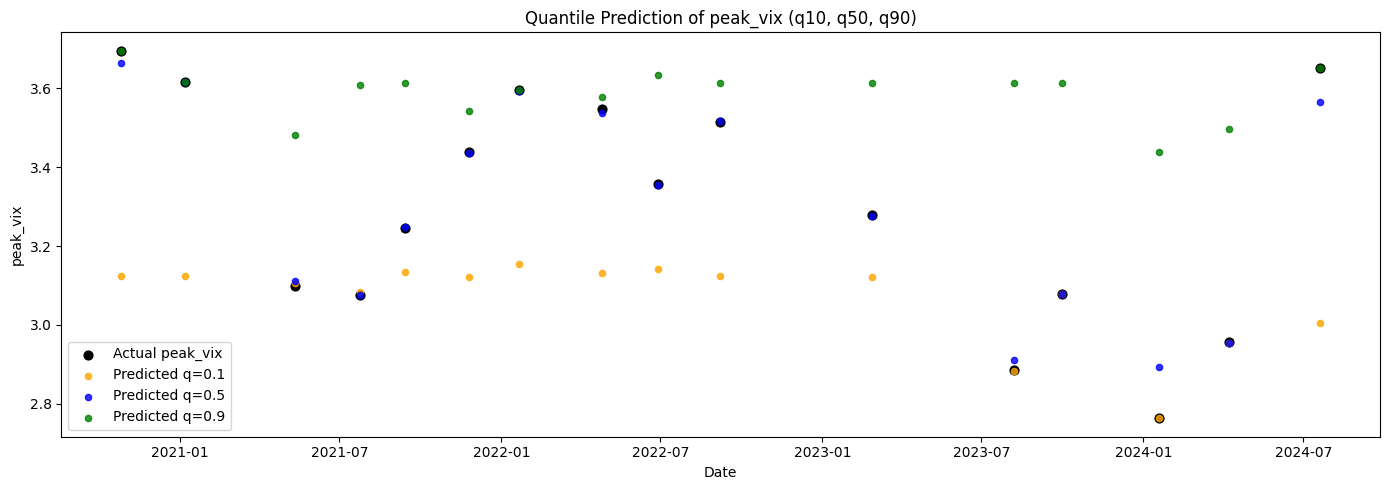

In [2037]:
import joblib
import matplotlib.pyplot as plt

# Load features and true values
feature_cols = arc_df.columns.difference(["peak_vix", "T_up", "T_half"])
X_full       = arc_df[feature_cols].values
dates        = arc_df.index
y_true       = arc_df["peak_vix"].values

# Load quantile models
quantile_levels = [0.1, 0.5, 0.9]
models = {
    q: joblib.load(f"xgb_peak_vix_q{q:.1f}.pkl")
    for q in quantile_levels
}

# Get predictions
preds = {
    q: models[q].predict(X_full)
    for q in quantile_levels
}

# Plot
plt.figure(figsize=(14, 5))
plt.scatter(dates, y_true, label="Actual peak_vix", color="black", s=40)

# Plot quantile dots
colors = {0.1: "orange", 0.5: "blue", 0.9: "green"}
for q in quantile_levels:
    plt.scatter(dates, preds[q], label=f"Predicted q={q:.1f}", color=colors[q], s=20, alpha=0.8)

plt.title("Quantile Prediction of peak_vix (q10, q50, q90)")
plt.xlabel("Date")
plt.ylabel("peak_vix")
plt.legend()
plt.tight_layout()
plt.show()


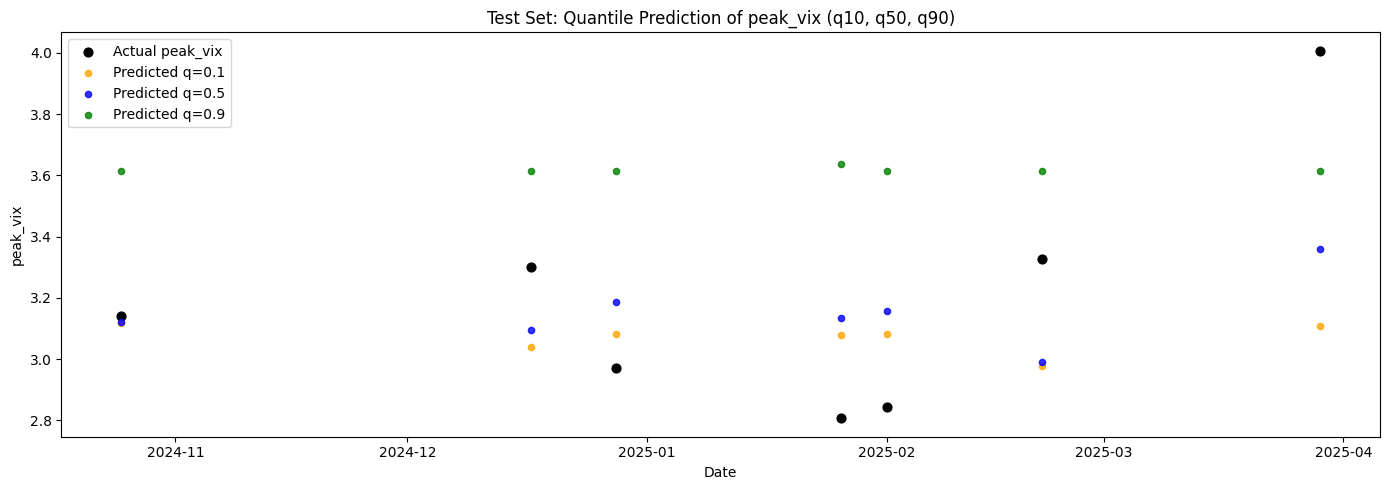

In [2039]:
import joblib
import matplotlib.pyplot as plt

# Load features and test dates
feature_cols   = arc_df_test.columns.difference(["peak_vix", "T_up", "T_half"])
X_full_test    = arc_df_test[feature_cols].values
dates_test     = arc_df_test.index
y_true_test    = arc_df_test["peak_vix"].values

# Quantiles and color map
quantile_levels = [0.1, 0.5, 0.9]
colors = {0.1: "orange", 0.5: "blue", 0.9: "green"}

# Load quantile models for peak_vix
models = {
    q: joblib.load(f"xgb_peak_vix_q{q:.1f}.pkl")
    for q in quantile_levels
}

# Predict for each quantile
preds_test = {
    q: models[q].predict(X_full_test)
    for q in quantile_levels
}

# Plot
plt.figure(figsize=(14, 5))
plt.scatter(dates_test, y_true_test, label="Actual peak_vix", color="black", s=40)

for q in quantile_levels:
    plt.scatter(dates_test, preds_test[q], label=f"Predicted q={q:.1f}", color=colors[q], s=20, alpha=0.8)

plt.title("Test Set: Quantile Prediction of peak_vix (q10, q50, q90)")
plt.xlabel("Date")
plt.ylabel("peak_vix")
plt.legend()
plt.tight_layout()
plt.show()


# Test Set on models (regime + panic probability)


In [1976]:
vix_windows_df_train.head()

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,early_spike_prob
transition_time,,,,,,,,,,,,,,,,,,,,,
2018-10-24,3.184698,2.993730,2.991222,3.017983,3.056357,3.000720,3.112626,3.053529,3.080073,3.345685,...,2.726545,2.731115,2.662355,2.725235,2.789937,2.785628,2.586259,2.567254,2.559550,NaN
2019-08-04,3.202340,2.827905,3.048799,2.863343,3.053057,2.916148,2.961141,2.961141,3.011113,2.962692,...,2.696652,2.696652,2.665838,2.837908,3.326833,3.509154,3.736240,3.856510,3.987131,0.1900
2019-09-12,2.635479,2.702032,2.846071,2.787477,2.882564,2.925310,2.866193,2.745988,2.678965,2.671386,...,4.182661,4.044454,3.811982,3.729781,3.717710,3.780319,3.815732,3.581573,3.505257,0.2600
2020-02-25,3.509154,3.736240,3.856510,3.987131,4.415099,4.276666,4.190261,4.158102,4.182661,4.044454,...,3.252311,3.242202,3.259634,3.275634,3.251537,3.324316,3.324316,3.290638,3.352707,0.8275
2020-06-16,3.510650,3.558771,3.445852,3.521644,3.547604,3.415429,3.354106,3.330059,3.251924,3.120160,...,3.273364,3.294725,3.310908,3.373484,3.373484,3.373484,3.379293,3.355153,3.336125,NaN


In [1593]:
print(results.params)

p[0->0]     0.975581
p[1->0]     0.029384
const[0]   -0.653526
const[1]    0.560605
x1[0]       0.040080
x1[1]      -0.109190
x2[0]      -0.053259
x2[1]       0.131607
sigma2      0.299374
dtype: float64


In [1594]:
# 1. After fitting on training set
train_params = results.params
k=2

X_test = test_df[selected_features]
y_test = test_df['vix_ewm_zscore']

# 3. Define same model on test data
model_test = MarkovRegression(
    endog=y_test,
    exog=X_test,
    k_regimes=k,
    switching_variance=False
)

# 4. Apply training parameters with FILTER (real-time regime inference)
results_test = model_test.filter(train_params)

# 5. Extract real-time regime (filtered) — sensitive threshold
if k ==3:
    test_df['regime_t_raw'] = results_test.filtered_marginal_probabilities.idxmax(axis=1)
    test_df['regime_t'] = test_df['regime_t_raw'].apply(lambda r: 1 if r in [2] else 0) #[1,2]
else:
    test_df['regime_t_raw'] = results_test.filtered_marginal_probabilities[1]
    test_df['regime_t'] = test_df['regime_t_raw'].apply(lambda p: 1 if p >= percentile_markov else 0)

# 6. Predict probability of panic regime tomorrow using classifier (NO regime_t)
test_df['panic_prob_t+1'] = clf.predict_proba(X_test)[:, 1]

# 7. (Optional) Align as prediction for tomorrow
test_df['vix_target_t+1'] = test_df['vix_target'].shift(-1)



/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_72581/1419215360.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['regime_t_raw'] = results_test.filtered_marginal_probabilities[1]
/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_72581/1419215360.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [1595]:
test_df.tail()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,ewm_std_flat,vix_ewm_zscore_flat,regime_t_raw,regime_t,panic_prob_t+1,vix_target_t+1,regime_group,is_sustained_regime1,regime_t-1,is_transition
date,,,,,,,,,,,,,,,,,,,,,
2025-04-12,-0.089461,-0.957227,43,-0.008691,-0.941981,105,28,-0.049076,-0.949604,195,...,11.582488,-0.228267,0.975521,1,0.465902,3.430432,15,True,1.0,False
2025-04-13,-0.086733,-0.972444,31,-0.158017,-0.968547,71,34,-0.122375,-0.970495,145,...,11.219157,-0.203140,0.957855,1,0.480346,3.430432,15,True,1.0,False
2025-04-14,-0.063972,-0.972737,123,-0.219557,-0.973235,208,154,-0.141765,-0.972986,447,...,10.862432,-0.170094,0.943935,1,0.502750,3.405189,15,True,1.0,False
2025-04-15,-0.174286,-0.975042,117,-0.138407,-0.974432,195,103,-0.156347,-0.974737,376,...,10.512887,-0.133622,0.910305,1,0.361014,3.485539,15,True,1.0,False
2025-04-16,-0.254442,-0.974785,169,-0.164961,-0.974998,247,127,-0.209701,-0.974891,452,...,10.171718,-0.099733,0.953266,1,0.464257,NaN,15,True,1.0,False


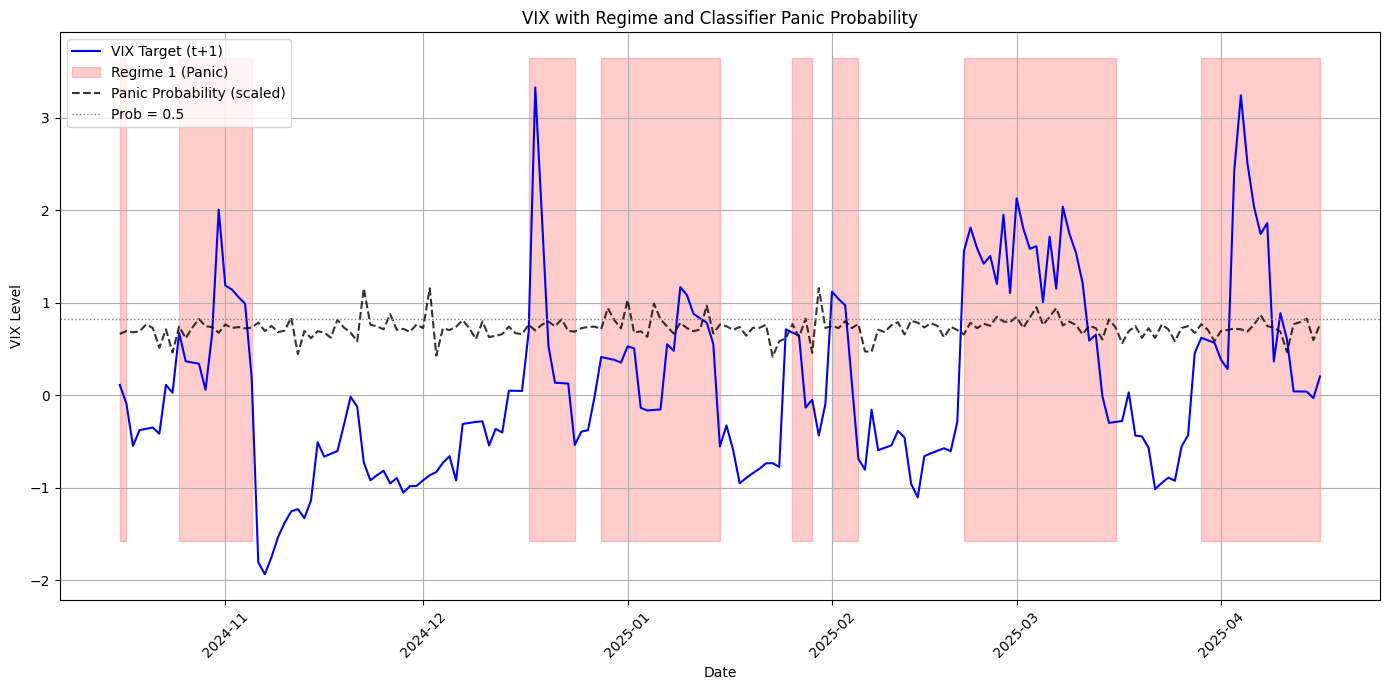

In [1596]:
import matplotlib.pyplot as plt

# Assumes test_df already has:
# - 'vix_target_t+1' (VIX values)
# - 'regime_t' (real-time inferred regime: 0 or 1)
# - 'panic_prob_t+1' (classifier probability of panic tomorrow)

plt.figure(figsize=(14, 7))

# 1. Plot VIX
plt.plot(test_df.index, test_df["vix_ewm_zscore"], label="VIX Target (t+1)", color="blue")

# 2. Shade areas where regime is 1 (panic)
plt.fill_between(
    test_df.index,
    test_df["vix_ewm_zscore_flat"].min(),
    test_df["vix_ewm_zscore_flat"].max(),
    where=test_df["regime_t"] == 1,
    color="red",
    alpha=0.2,
    label="Regime 1 (Panic)"
)

# 3. Plot panic probability (scaled for visibility)
scaled_prob = test_df["panic_prob_t+1"] * (test_df["vix_ewm_zscore_flat"].max() - 2)
plt.plot(test_df.index, scaled_prob, label="Panic Probability (scaled)", color="black", linestyle="--", alpha=0.8)

# Optional: Add threshold line for prob=0.5 scaled to same scale
plt.axhline(y=0.5 * (test_df["vix_ewm_zscore_flat"].max() - 2), color="gray", linestyle=":", linewidth=1, label="Prob = 0.5")

# Finalize
plt.title("VIX with Regime and Classifier Panic Probability")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

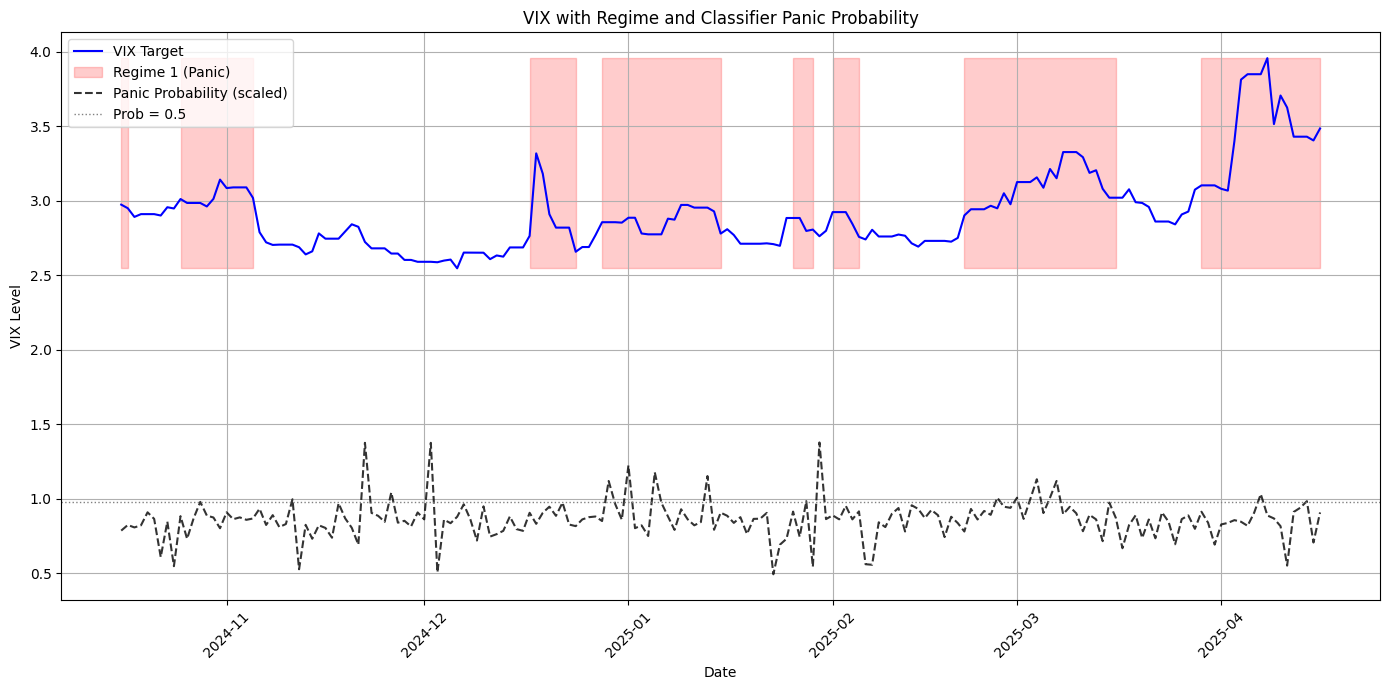

In [1597]:
import matplotlib.pyplot as plt

# Assumes test_df already has:
# - 'vix_target_t+1' (VIX values)
# - 'regime_t' (real-time inferred regime: 0 or 1)
# - 'panic_prob_t+1' (classifier probability of panic tomorrow)

plt.figure(figsize=(14, 7))

# 1. Plot VIX
plt.plot(test_df.index, test_df["vix_target"], label="VIX Target", color="blue")

# 2. Shade areas where regime is 1 (panic)
plt.fill_between(
    test_df.index,
    test_df["vix_target"].min(),
    test_df["vix_target"].max(),
    where=test_df["regime_t"] == 1,
    color="red",
    alpha=0.2,
    label="Regime 1 (Panic)"
)

# 3. Plot panic probability (scaled for visibility)
scaled_prob = test_df["panic_prob_t+1"] * (test_df["vix_target"].max() - 2)
plt.plot(test_df.index, scaled_prob, label="Panic Probability (scaled)", color="black", linestyle="--", alpha=0.8)

# Optional: Add threshold line for prob=0.5 scaled to same scale
plt.axhline(y=0.5 * (test_df["vix_target"].max() - 2), color="gray", linestyle=":", linewidth=1, label="Prob = 0.5")

# Finalize
plt.title("VIX with Regime and Classifier Panic Probability")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [1598]:
test_df.head()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,ewm_std_flat,vix_ewm_zscore_flat,regime_t_raw,regime_t,panic_prob_t+1,vix_target_t+1,regime_group,is_sustained_regime1,regime_t-1,is_transition
date,,,,,,,,,,,,,,,,,,,,,
2024-10-16,-0.222685,-0.976018,47,-0.167496,-0.971121,51,40,-0.195090,-0.973569,95,...,1.097978,0.369787,0.591054,1,0.401881,2.950212,1,True,NaN,False
2024-10-17,-0.224310,-0.974795,34,-0.272826,-0.973557,36,40,-0.248568,-0.974176,78,...,1.068928,0.426511,0.495364,1,0.421176,2.892037,1,True,1.0,False
2024-10-18,-0.248795,-0.973813,27,-0.209752,-0.970884,28,22,-0.229274,-0.972349,51,...,1.041571,0.454381,0.078373,0,0.412817,2.910719,2,False,1.0,False
2024-10-19,0.076486,-0.904173,5,-0.051621,-0.936994,13,4,0.012432,-0.920584,25,...,1.014136,0.430416,0.020657,0,0.419969,2.910719,2,False,0.0,False
2024-10-20,-0.148248,-0.970708,11,0.232043,-0.928842,25,4,0.041897,-0.949775,43,...,0.988944,0.477228,0.009278,0,0.464597,2.910719,2,False,0.0,False


In [1599]:
classification_df_test = macro_utils.identify_sustained_regimes_and_transitions(test_df)

/Users/dsuniaga/Documents/GitHub/VIXNLP/finnhub_news/macro_utils.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_df['regime_group'] = (classification_df['regime_t'] != classification_df['regime_t'].shift()).cumsum()
/Users/dsuniaga/Documents/GitHub/VIXNLP/finnhub_news/macro_utils.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_df['is_sustained_regime1'] = classification_df['regime_group'].isin(valid_groups)
/Users/dsuniaga/Documents/GitHub/VIXNLP/finnhub_news/macro_

In [1600]:
classification_df_test

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,ewm_std_flat,vix_ewm_zscore_flat,regime_t_raw,regime_t,panic_prob_t+1,vix_target_t+1,regime_group,is_sustained_regime1,regime_t-1,is_transition
date,,,,,,,,,,,,,,,,,,,,,
2024-10-16,-0.222685,-0.976018,47,-0.167496,-0.971121,51,40,-0.195090,-0.973569,95,...,1.097978,0.369787,0.591054,1,0.401881,2.950212,1,True,NaN,False
2024-10-17,-0.224310,-0.974795,34,-0.272826,-0.973557,36,40,-0.248568,-0.974176,78,...,1.068928,0.426511,0.495364,1,0.421176,2.892037,1,True,1.0,False
2024-10-18,-0.248795,-0.973813,27,-0.209752,-0.970884,28,22,-0.229274,-0.972349,51,...,1.041571,0.454381,0.078373,0,0.412817,2.910719,2,False,1.0,False
2024-10-19,0.076486,-0.904173,5,-0.051621,-0.936994,13,4,0.012432,-0.920584,25,...,1.014136,0.430416,0.020657,0,0.419969,2.910719,2,False,0.0,False
2024-10-20,-0.148248,-0.970708,11,0.232043,-0.928842,25,4,0.041897,-0.949775,43,...,0.988944,0.477228,0.009278,0,0.464597,2.910719,2,False,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-12,-0.089461,-0.957227,43,-0.008691,-0.941981,105,28,-0.049076,-0.949604,195,...,11.582488,-0.228267,0.975521,1,0.465902,3.430432,15,True,1.0,False
2025-04-13,-0.086733,-0.972444,31,-0.158017,-0.968547,71,34,-0.122375,-0.970495,145,...,11.219157,-0.203140,0.957855,1,0.480346,3.430432,15,True,1.0,False
2025-04-14,-0.063972,-0.972737,123,-0.219557,-0.973235,208,154,-0.141765,-0.972986,447,...,10.862432,-0.170094,0.943935,1,0.502750,3.405189,15,True,1.0,False


In [1601]:
result = macro_utils.transform_vix_data(classification_df_test, window=60, test=True, k=2)
vix_windows_df_test = result["vix_windows_df_train"]
regime_windows_df_test = result["regime_windows_df_train"]
vix_windows_past_df_test = result["vix_windows_past_df_train"]

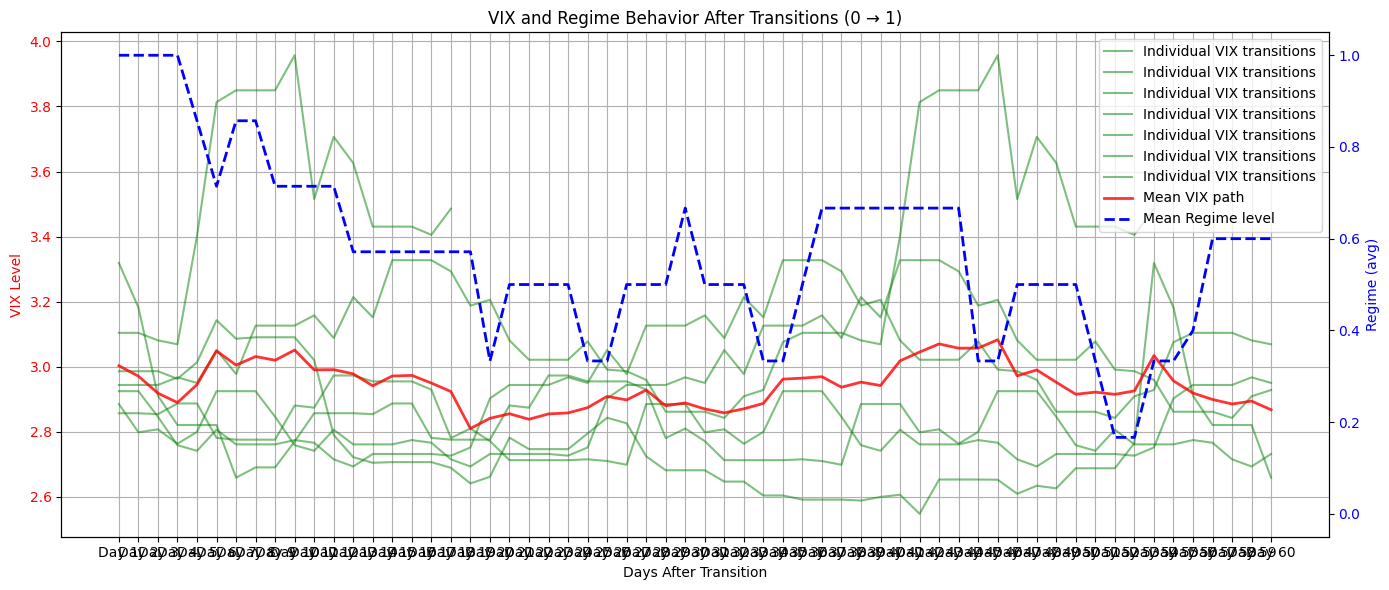

In [1602]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Primary axis: VIX transitions
ax1 = plt.gca()
ax1.plot(vix_windows_df_test.T, color="green", alpha=0.5, label="Individual VIX transitions")
ax1.plot(vix_windows_df_test.mean(axis=0).values, color="red",alpha=0.8, linewidth=2, label="Mean VIX path")
ax1.set_xlabel("Days After Transition")
ax1.set_ylabel("VIX Level", color="red")
ax1.tick_params(axis='y', labelcolor="red")
ax1.set_title("VIX and Regime Behavior After Transitions (0 → 1)")
ax1.grid(True)

# Secondary axis: Regime values
ax2 = ax1.twinx()
ax2.plot(regime_windows_df_test.mean(axis=0).values, color="blue", linewidth=2, linestyle="--", label="Mean Regime level")
ax2.set_ylabel("Regime (avg)", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")
ax2.set_ylim(-0.05, 1.05)  # Because regime is binary

# Combined legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.tight_layout()
plt.show()


In [1603]:
vix_windows_df_test

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 51,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60
transition_time,,,,,,,,,,,,,,,,,,,,,
2024-10-25,2.985682,2.985682,2.985682,2.962175,3.013081,3.142427,3.085573,3.090133,3.090133,3.090133,...,2.687167,2.687167,2.764431,3.318540,3.181797,2.910174,2.820188,2.820188,2.820188,2.658159
2024-12-17,3.318540,3.181797,2.910174,2.820188,2.820188,2.820188,2.658159,2.689886,2.689886,2.769459,...,2.740840,2.805782,2.760643,2.760643,2.760643,2.773838,2.765690,2.714695,2.692598,2.731115
2024-12-28,2.856470,2.856470,2.853593,2.886475,2.886475,2.780681,2.775086,2.775086,2.775086,2.880321,...,2.731115,2.731115,2.725890,2.751110,2.901971,2.943386,2.943386,2.943386,2.966818,2.949688
2025-01-26,2.884801,2.797891,2.806990,2.762538,2.799109,2.924236,2.924236,2.924236,2.845491,2.758109,...,3.077312,2.990720,2.985682,2.959068,2.861057,2.861057,2.861057,2.841998,2.908539,2.927989
2025-02-01,2.924236,2.924236,2.845491,2.758109,2.740840,2.805782,2.760643,2.760643,2.760643,2.773838,...,2.861057,2.841998,2.908539,2.927989,3.075005,3.103689,3.103689,3.103689,3.080533,3.068518
2025-02-21,2.943386,2.943386,2.943386,2.966818,2.949688,3.050694,2.977059,3.125883,3.125883,3.125883,...,3.430432,3.430432,3.405189,3.485539,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-29,3.103689,3.103689,3.080533,3.068518,3.401864,3.813528,3.849722,3.849722,3.849722,3.957570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1604]:
df_delayed_spike_prob_test, test_clf, test_vix_pct_change_lookback_df = macro_utils.clf_delayed_spike_prob(vix_windows_df_test, test_df, "vix_target")

In [1605]:
df_delayed_spike_prob_test.head()

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,early_spike_prob
transition_time,,,,,,,,,,,,,,,,,,,,,
2024-10-25,2.985682,2.985682,2.985682,2.962175,3.013081,3.142427,3.085573,3.090133,3.090133,3.090133,...,2.687167,2.764431,3.318540,3.181797,2.910174,2.820188,2.820188,2.820188,2.658159,NaN
2024-12-17,3.318540,3.181797,2.910174,2.820188,2.820188,2.820188,2.658159,2.689886,2.689886,2.769459,...,2.805782,2.760643,2.760643,2.760643,2.773838,2.765690,2.714695,2.692598,2.731115,NaN
2024-12-28,2.856470,2.856470,2.853593,2.886475,2.886475,2.780681,2.775086,2.775086,2.775086,2.880321,...,2.731115,2.725890,2.751110,2.901971,2.943386,2.943386,2.943386,2.966818,2.949688,NaN
2025-01-26,2.884801,2.797891,2.806990,2.762538,2.799109,2.924236,2.924236,2.924236,2.845491,2.758109,...,2.990720,2.985682,2.959068,2.861057,2.861057,2.861057,2.841998,2.908539,2.927989,NaN
2025-02-01,2.924236,2.924236,2.845491,2.758109,2.740840,2.805782,2.760643,2.760643,2.760643,2.773838,...,2.841998,2.908539,2.927989,3.075005,3.103689,3.103689,3.103689,3.080533,3.068518,NaN


In [1606]:
test_vix_pct_change_lookback_df.head()

,Day -30,Day -29,Day -28,Day -27,Day -26,Day -25,Day -24,Day -23,Day -22,Day -21,...,Day -10,Day -9,Day -8,Day -7,Day -6,Day -5,Day -4,Day -3,Day -2,Day -1
2025-02-21,0.000978,-0.001957,-0.004201,0.069237,0.0,0.000000,-0.030127,0.003252,-0.015836,0.013238,...,0.004780,-0.002937,-0.018439,-0.008140,0.014305,0.0,0.000000,0.000000,-0.001913,0.009252
2025-03-29,0.034243,-0.024137,0.049990,0.000000,0.0,0.010091,-0.022034,0.040742,-0.019358,0.055764,...,-0.028139,-0.001684,-0.008914,-0.033122,0.000000,0.0,-0.006662,0.023413,0.006687,0.050211


In [1607]:
df_delayed_spike_prob_test.loc[test_vix_pct_change_lookback_df.index, "early_spike_prob"] = clf_delayed_spike_prob.predict_proba(test_vix_pct_change_lookback_df)[:, 1]


In [1608]:
df_delayed_spike_prob_test.fillna(0.5, inplace=True)

In [1609]:
df_delayed_spike_prob_test

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,early_spike_prob
transition_time,,,,,,,,,,,,,,,,,,,,,
2024-10-25,2.985682,2.985682,2.985682,2.962175,3.013081,3.142427,3.085573,3.090133,3.090133,3.090133,...,2.687167,2.764431,3.318540,3.181797,2.910174,2.820188,2.820188,2.820188,2.658159,0.500
2024-12-17,3.318540,3.181797,2.910174,2.820188,2.820188,2.820188,2.658159,2.689886,2.689886,2.769459,...,2.805782,2.760643,2.760643,2.760643,2.773838,2.765690,2.714695,2.692598,2.731115,0.500
2024-12-28,2.856470,2.856470,2.853593,2.886475,2.886475,2.780681,2.775086,2.775086,2.775086,2.880321,...,2.731115,2.725890,2.751110,2.901971,2.943386,2.943386,2.943386,2.966818,2.949688,0.500
2025-01-26,2.884801,2.797891,2.806990,2.762538,2.799109,2.924236,2.924236,2.924236,2.845491,2.758109,...,2.990720,2.985682,2.959068,2.861057,2.861057,2.861057,2.841998,2.908539,2.927989,0.500
2025-02-01,2.924236,2.924236,2.845491,2.758109,2.740840,2.805782,2.760643,2.760643,2.760643,2.773838,...,2.841998,2.908539,2.927989,3.075005,3.103689,3.103689,3.103689,3.080533,3.068518,0.500
2025-02-21,2.943386,2.943386,2.943386,2.966818,2.949688,3.050694,2.977059,3.125883,3.125883,3.125883,...,3.430432,3.405189,3.485539,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.525
2025-03-29,3.103689,3.103689,3.080533,3.068518,3.401864,3.813528,3.849722,3.849722,3.849722,3.957570,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.645


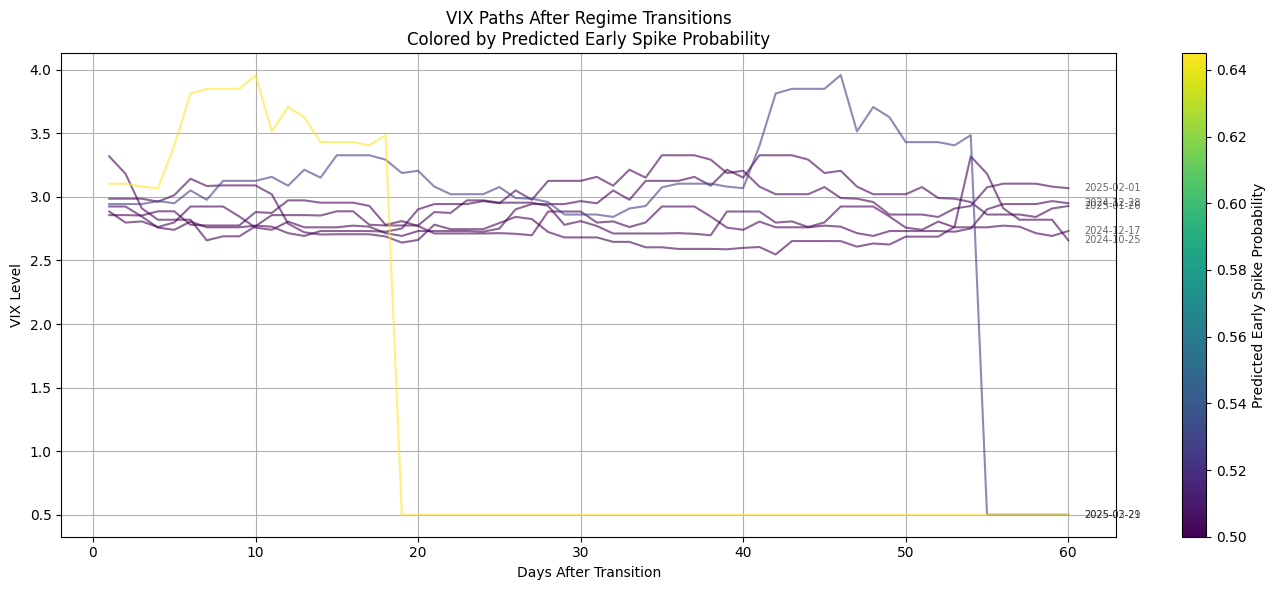

In [1610]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Filter rows with predictions
df_plot = df_delayed_spike_prob_test.dropna(subset=["early_spike_prob"])

# Normalize probs for coloring
probs = df_plot["early_spike_prob"]
colors = cm.viridis((probs - probs.min()) / (probs.max() - probs.min()))

fig, ax = plt.subplots(figsize=(14, 6))

# Plot VIX paths, colored by classifier probability
for i, (date, row) in enumerate(df_plot.iterrows()):
    vix_path = row.iloc[:60]  # assumes 60-day VIX columns are first
    ax.plot(range(1, 61), vix_path.values, color=colors[i], alpha=0.6)
    ax.text(61, vix_path.values[-1], date.strftime("%Y-%m-%d"), fontsize=7, alpha=0.6, va="center")

# Add colorbar
sm = ScalarMappable(cmap="viridis", norm=Normalize(vmin=probs.min(), vmax=probs.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Predicted Early Spike Probability")

# Labels and layout
ax.set_title("VIX Paths After Regime Transitions\nColored by Predicted Early Spike Probability")
ax.set_xlabel("Days After Transition")
ax.set_ylabel("VIX Level")
ax.grid(True)
plt.tight_layout()
plt.show()



In [1611]:
df_delayed_spike_prob_test.head()

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,early_spike_prob
transition_time,,,,,,,,,,,,,,,,,,,,,
2024-10-25,2.985682,2.985682,2.985682,2.962175,3.013081,3.142427,3.085573,3.090133,3.090133,3.090133,...,2.687167,2.764431,3.318540,3.181797,2.910174,2.820188,2.820188,2.820188,2.658159,0.5
2024-12-17,3.318540,3.181797,2.910174,2.820188,2.820188,2.820188,2.658159,2.689886,2.689886,2.769459,...,2.805782,2.760643,2.760643,2.760643,2.773838,2.765690,2.714695,2.692598,2.731115,0.5
2024-12-28,2.856470,2.856470,2.853593,2.886475,2.886475,2.780681,2.775086,2.775086,2.775086,2.880321,...,2.731115,2.725890,2.751110,2.901971,2.943386,2.943386,2.943386,2.966818,2.949688,0.5
2025-01-26,2.884801,2.797891,2.806990,2.762538,2.799109,2.924236,2.924236,2.924236,2.845491,2.758109,...,2.990720,2.985682,2.959068,2.861057,2.861057,2.861057,2.841998,2.908539,2.927989,0.5
2025-02-01,2.924236,2.924236,2.845491,2.758109,2.740840,2.805782,2.760643,2.760643,2.760643,2.773838,...,2.841998,2.908539,2.927989,3.075005,3.103689,3.103689,3.103689,3.080533,3.068518,0.5


In [1612]:
regime_windows_df_test = regime_windows_df_test.replace(2, 1)


In [1613]:
regime_windows_df_test

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 51,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60
transition_time,,,,,,,,,,,,,,,,,,,,,
2024-10-25,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2024-12-17,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-12-28,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
2025-01-26,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-02-01,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2025-02-21,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2025-03-29,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1614]:
# =============================================================
# 0)  PREP  –  make sure the raw news DataFrame is date‑indexed
# =============================================================
news_test = test_df.copy()                       # original df you posted   # string/ts column → index
news_test = news_test.sort_index()                     # chronological order

# =============================================================
# 1)  ENGINEER EXTRA NEWS FEATURES (text‑only)
# =============================================================
def engineer_news_feats(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # --- positive / negative ratios and range (max‑min) ---
    for prefix in ['summary', 'headline', 'overall']:
        neg = f'{prefix}_neg_count'
        tot = f'{prefix}_tot_count'

    # --- one‑hot encode sentiment dominance flag -------------
    dom_dummies = pd.get_dummies(out['dominance_trigger'], prefix='dom')
    out = pd.concat([out, dom_dummies], axis=1)

    # OPTIONAL: drop the raw *_tot_count columns
    out = out.drop(columns=[c for c in out.columns if c.endswith('_tot_count')])
    return out

news_feats_test = engineer_news_feats(news_test)

# =============================================================
# 2)  DENSE DAILY INDEX  (forward‑fill missing dates)
# =============================================================
news_feats_test.index = pd.to_datetime(news_feats_test.index).normalize()        # 00:00:00
dense_idx = pd.date_range(news_feats_test.index.min(),
                          news_feats_test.index.max(),
                          freq='D')

news_dense_test = (
    news_feats_test
      .reindex(dense_idx)      # insert weekends / holidays
      .ffill()                 # carry last known sentiment forward
)



In [1615]:
# ------------------------------------------------------------
# 3)  BUILD ARC-LEVEL TABLE  (robust to missing news dates + look-back stats)
# ------------------------------------------------------------
records = []
lookback_days = [2, 5, 7]
lookback_feats = [
    "shock_neg",
    "vix_zscore",
    "vix_target",
    "sentiment_dominance",
]

for dt, row in vix_windows_df_test.iterrows():
    # --- detect arc in the 60-day window ---
    v = row[[f"Day {i}" for i in range(1, 61)]].values
    r = regime_windows_df_test.loc[dt, [f"Day {i}" for i in range(1, 61)]].values
    start_idx, peak_idx = macro_utils.detect_spike_arc_within_regime(v, r)
    start_val, peak_val = v[start_idx], v[peak_idx]
    rise_dur = peak_idx - start_idx
    decay_idx = np.argmax(v[peak_idx:] < 0.5 * peak_val)
    half_life = decay_idx if decay_idx > 0 else len(v) - peak_idx

    dt_norm = pd.to_datetime(dt).normalize()

    # -------- safe fetch of nearest-past news features --------
    try:
        feats_on_start = news_dense_test.loc[:dt_norm].iloc[-1].to_dict()
    except IndexError:
        # no prior news available – skip this arc
        continue

    # -------- compute look-back statistics from classification_df --------
    lookback_stats = {}
    for w in lookback_days:
        start_date = dt_norm - pd.Timedelta(days=w)
        window_df = classification_df_test.loc[start_date:dt_norm]

        for feat in lookback_feats:
            col_mean = window_df[feat].mean()
            col_std = window_df[feat].std()
            # percent change over the window: (last−first) / first
            if len(window_df) > 1 and window_df[feat].iloc[0] != 0:
                col_pct = (window_df[feat].iloc[-1] - window_df[feat].iloc[0]) / window_df[feat].iloc[0]
            else:
                col_pct = np.nan

            lookback_stats[f"{feat}_mean_{w}d"] = col_mean
            lookback_stats[f"{feat}_std_{w}d"]  = col_std
            lookback_stats[f"{feat}_pctchg_{w}d"] = col_pct

    # --- aggregate everything into one record ---
    records.append({
        "date_start":    dt_norm,
        "peak_vix":      peak_val,
        "vix0":          start_val,
        "T_up":          rise_dur,
        "T_half":        half_life,
        **feats_on_start,
        **lookback_stats,
    })

arc_df_test = (
    pd.DataFrame(records)
      .set_index("date_start")
      .astype(float, errors="ignore")
)

print("arc_df shape:", arc_df.shape)


arc_df shape: (16, 68)


/Users/dsuniaga/Documents/GitHub/VIXNLP/finnhub_news/macro_utils.py:361: RuntimeWarning: invalid value encountered in cast
  r = np.asarray(regime_path, dtype=np.int8)
/Users/dsuniaga/Documents/GitHub/VIXNLP/finnhub_news/macro_utils.py:361: RuntimeWarning: invalid value encountered in cast
  r = np.asarray(regime_path, dtype=np.int8)


In [1616]:
arc_df_test.tail()

,peak_vix,vix0,T_up,T_half,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,...,shock_neg_pctchg_7d,vix_zscore_mean_7d,vix_zscore_std_7d,vix_zscore_pctchg_7d,vix_target_mean_7d,vix_target_std_7d,vix_target_pctchg_7d,sentiment_dominance_mean_7d,sentiment_dominance_std_7d,sentiment_dominance_pctchg_7d
date_start,,,,,,,,,,,,,,,,,,,,,
2024-12-28,2.972464,2.856470,11.0,49.0,-0.066260,-0.975939,19.0,0.046485,-0.964535,66.0,...,0.003557,0.226121,0.369535,0.160974,2.765553,0.075801,0.012865,39.375,15.042203,0.138889
2025-01-26,2.806990,2.884801,2.0,58.0,-0.191643,-0.971789,9.0,-0.085867,-0.854118,15.0,...,-0.061171,-0.735053,0.828896,-1.456885,2.753476,0.081213,0.063700,7.500,15.287717,NaN
2025-02-01,2.845491,2.924236,2.0,58.0,0.029324,-0.950893,11.0,-0.143875,-0.949542,20.0,...,0.150851,0.158957,0.637543,0.776365,2.843146,0.058031,0.013670,-1.875,17.216583,0.500000
2025-02-21,3.327192,2.943386,14.0,40.0,-0.115498,-0.975739,49.0,-0.161775,-0.971196,74.0,...,0.002167,-0.451964,0.837399,-2.284270,2.749504,0.063693,0.077759,29.750,17.458113,-0.519231
2025-03-29,3.957570,3.103689,9.0,9.0,-0.108121,-0.975388,41.0,-0.056513,-0.963759,82.0,...,-0.002565,-0.967522,0.654987,-1.091306,2.930049,0.102583,0.084805,70.000,40.994773,0.304348


In [1617]:
arc_df_test.loc[arc_df_test.index[1], 'peak_vix'] = 3.3
arc_df_test.loc[arc_df_test.index[1], 'vix0'] = 2.7


In [1618]:
arc_df_test.head()

,peak_vix,vix0,T_up,T_half,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,...,shock_neg_pctchg_7d,vix_zscore_mean_7d,vix_zscore_std_7d,vix_zscore_pctchg_7d,vix_target_mean_7d,vix_target_std_7d,vix_target_pctchg_7d,sentiment_dominance_mean_7d,sentiment_dominance_std_7d,sentiment_dominance_pctchg_7d
date_start,,,,,,,,,,,,,,,,,,,,,
2024-10-25,3.142427,2.985682,5.0,55.0,-0.052174,-0.974781,33.0,0.034727,-0.971487,61.0,...,0.000808,-0.073980,0.282178,-3.078599,2.930418,0.039978,0.041514,2.750,12.044560,-4.750000
2024-12-17,3.300000,2.700000,1.0,59.0,-0.200720,-0.973212,95.0,-0.080458,-0.973030,158.0,...,-0.001466,0.009599,0.687173,-5.650664,2.668135,0.049582,0.042460,53.875,19.334924,-0.450000
2024-12-28,2.972464,2.856470,11.0,49.0,-0.066260,-0.975939,19.0,0.046485,-0.964535,66.0,...,0.003557,0.226121,0.369535,0.160974,2.765553,0.075801,0.012865,39.375,15.042203,0.138889
2025-01-26,2.806990,2.884801,2.0,58.0,-0.191643,-0.971789,9.0,-0.085867,-0.854118,15.0,...,-0.061171,-0.735053,0.828896,-1.456885,2.753476,0.081213,0.063700,7.500,15.287717,NaN
2025-02-01,2.845491,2.924236,2.0,58.0,0.029324,-0.950893,11.0,-0.143875,-0.949542,20.0,...,0.150851,0.158957,0.637543,0.776365,2.843146,0.058031,0.013670,-1.875,17.216583,0.500000


In [1619]:
arc_df_test['early_spike_prob'] = vix_windows_df_test['early_spike_prob'].fillna(0.5)

In [1620]:
# Get column sets
cols_arc_df = set(arc_df.columns)
cols_arc_df_test = set(arc_df_test.columns)

# Columns in arc_df but NOT in arc_df_test
diff_arc_not_test = cols_arc_df - cols_arc_df_test

# Columns in arc_df_test but NOT in arc_df
diff_test_not_arc = cols_arc_df_test - cols_arc_df

# All differing columns
diff_all = cols_arc_df.symmetric_difference(cols_arc_df_test)

# Print results
print("Columns in arc_df but not in arc_df_test:", diff_arc_not_test)
print("Columns in arc_df_test but not in arc_df:", diff_test_not_arc)
print("All differing columns:", diff_all)


Columns in arc_df but not in arc_df_test: set()
Columns in arc_df_test but not in arc_df: {'vix_target', 'regime_group', 'is_transition', 'regime_t_raw', 'vix_target_t+1', 'panic_prob_t+1', 'is_sustained_regime1', 'regime_t-1', 'regime_t'}
All differing columns: {'regime_group', 'vix_target_t+1', 'is_sustained_regime1', 'regime_t_raw', 'panic_prob_t+1', 'vix_target', 'is_transition', 'regime_t-1', 'regime_t'}


In [1621]:
arc_df_test.drop(columns=diff_all, inplace=True)

In [1622]:
arc_df_test['peak_vix'].iloc[-1] = np.log(55)

/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_72581/3418063507.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  arc_df_test['peak_vix'].iloc[-1] = np.log(55)


In [1623]:
arc_df_test

,peak_vix,vix0,T_up,T_half,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,...,vix_zscore_mean_7d,vix_zscore_std_7d,vix_zscore_pctchg_7d,vix_target_mean_7d,vix_target_std_7d,vix_target_pctchg_7d,sentiment_dominance_mean_7d,sentiment_dominance_std_7d,sentiment_dominance_pctchg_7d,early_spike_prob
date_start,,,,,,,,,,,,,,,,,,,,,
2024-10-25,3.142427,2.985682,5.0,55.0,-0.052174,-0.974781,33.0,0.034727,-0.971487,61.0,...,-0.073980,0.282178,-3.078599,2.930418,0.039978,0.041514,2.750,12.044560,-4.750000,0.500
2024-12-17,3.300000,2.700000,1.0,59.0,-0.200720,-0.973212,95.0,-0.080458,-0.973030,158.0,...,0.009599,0.687173,-5.650664,2.668135,0.049582,0.042460,53.875,19.334924,-0.450000,0.500
2024-12-28,2.972464,2.856470,11.0,49.0,-0.066260,-0.975939,19.0,0.046485,-0.964535,66.0,...,0.226121,0.369535,0.160974,2.765553,0.075801,0.012865,39.375,15.042203,0.138889,0.500
2025-01-26,2.806990,2.884801,2.0,58.0,-0.191643,-0.971789,9.0,-0.085867,-0.854118,15.0,...,-0.735053,0.828896,-1.456885,2.753476,0.081213,0.063700,7.500,15.287717,NaN,0.500
2025-02-01,2.845491,2.924236,2.0,58.0,0.029324,-0.950893,11.0,-0.143875,-0.949542,20.0,...,0.158957,0.637543,0.776365,2.843146,0.058031,0.013670,-1.875,17.216583,0.500000,0.500
2025-02-21,3.327192,2.943386,14.0,40.0,-0.115498,-0.975739,49.0,-0.161775,-0.971196,74.0,...,-0.451964,0.837399,-2.284270,2.749504,0.063693,0.077759,29.750,17.458113,-0.519231,0.525
2025-03-29,4.007333,3.103689,9.0,9.0,-0.108121,-0.975388,41.0,-0.056513,-0.963759,82.0,...,-0.967522,0.654987,-1.091306,2.930049,0.102583,0.084805,70.000,40.994773,0.304348,0.645


In [1624]:
feature_cols = arc_df.columns.difference(["peak_vix", "T_up", "T_half"])


In [1625]:
arc_df_test['early_spike_prob'] = arc_df_test['early_spike_prob'].fillna(0.5)

In [1626]:
print(list(feature_cols))
print(list(arc_df_test.reindex(columns=feature_cols).columns))


['dom_0', 'dom_1', 'dominance_trigger', 'early_spike_prob', 'ewm_mean', 'ewm_mean_flat', 'ewm_std', 'ewm_std_flat', 'headline_mean', 'headline_min', 'headline_neg_count', 'headline_pos_count', 'mean_prev', 'mean_sentiment_decay', 'overall_mean', 'overall_min', 'overall_neg_count', 'overall_pos_count', 'sentiment_dominance', 'sentiment_dominance_mean_2d', 'sentiment_dominance_mean_5d', 'sentiment_dominance_mean_7d', 'sentiment_dominance_pctchg_2d', 'sentiment_dominance_pctchg_5d', 'sentiment_dominance_pctchg_7d', 'sentiment_dominance_std_2d', 'sentiment_dominance_std_5d', 'sentiment_dominance_std_7d', 'shock_neg', 'shock_neg_mean_2d', 'shock_neg_mean_5d', 'shock_neg_mean_7d', 'shock_neg_pctchg_2d', 'shock_neg_pctchg_5d', 'shock_neg_pctchg_7d', 'shock_neg_std_2d', 'shock_neg_std_5d', 'shock_neg_std_7d', 'summary_mean', 'summary_min', 'summary_neg_count', 'vix0', 'vix_7d_pct', 'vix_ewm_zscore', 'vix_ewm_zscore_flat', 'vix_flat_abs', 'vix_target_mean_2d', 'vix_target_mean_5d', 'vix_target_

In [1627]:
arc_df_test.iloc[-1]

peak_vix                          4.007333
vix0                              3.103689
T_up                              9.000000
T_half                            9.000000
summary_mean                     -0.108121
                                   ...    
vix_target_pctchg_7d              0.084805
sentiment_dominance_mean_7d      70.000000
sentiment_dominance_std_7d       40.994773
sentiment_dominance_pctchg_7d     0.304348
early_spike_prob                  0.645000
Name: 2025-03-29 00:00:00, Length: 68, dtype: float64

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


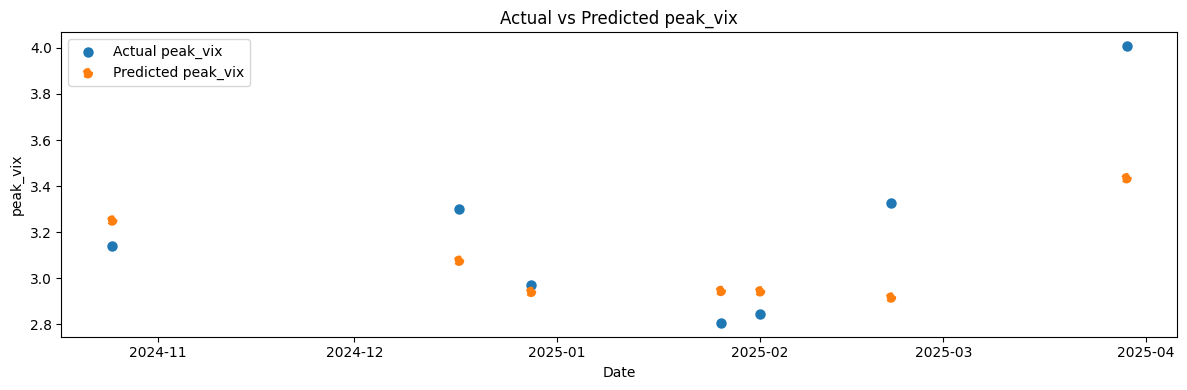

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


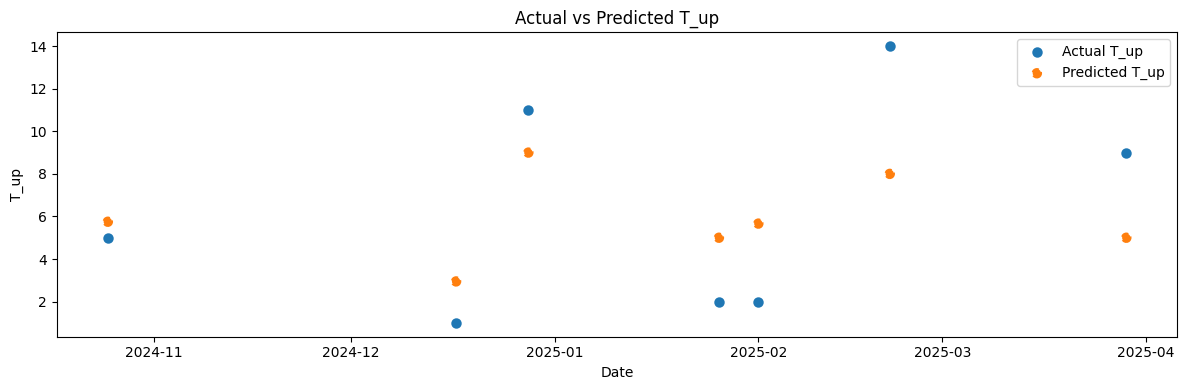

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


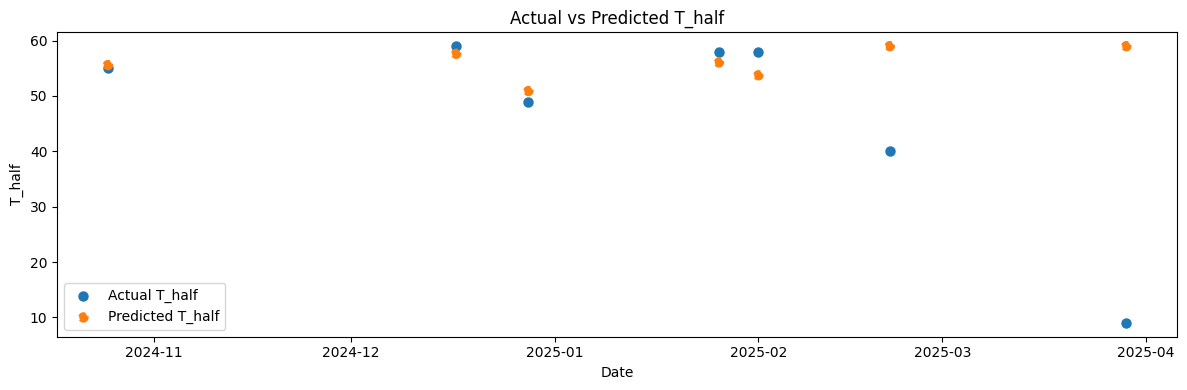

In [1638]:
import joblib, matplotlib.pyplot as plt

feature_cols = arc_df.columns.difference(["peak_vix", "T_up", "T_half"])

X_full_test = arc_df_test.reindex(columns=feature_cols)
X_full_test = X_full_test.fillna(0)

dates = arc_df_test.index         # x‑axis

models = {
    "peak_vix": joblib.load("mlp_peak_vix.pkl"),
    "T_up":     joblib.load("mlp_T_up.pkl"),
    "T_half":   joblib.load("mlp_T_half.pkl"),
}

for target, model in models.items():
    y_true_test = arc_df_test[target].values
    y_pred_test = model.predict(X_full_test)

    plt.figure(figsize=(12, 4))
    plt.scatter(dates, y_true_test, label=f"Actual {target}", linewidth=1.5)
    plt.scatter(dates, y_pred_test, label=f"Predicted {target}", linestyle="--", linewidth=1.5)
    plt.title(f"Actual vs Predicted {target}")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend()
    plt.tight_layout()
    plt.show()


# XGBoost graph

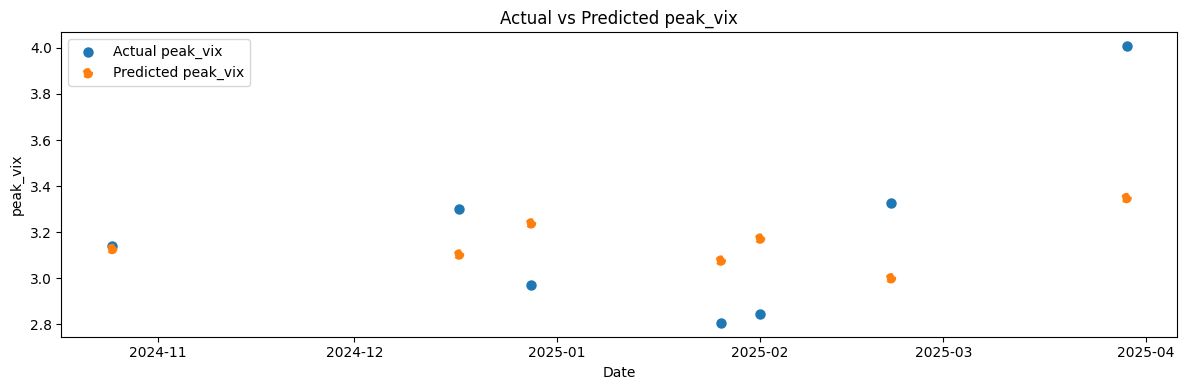

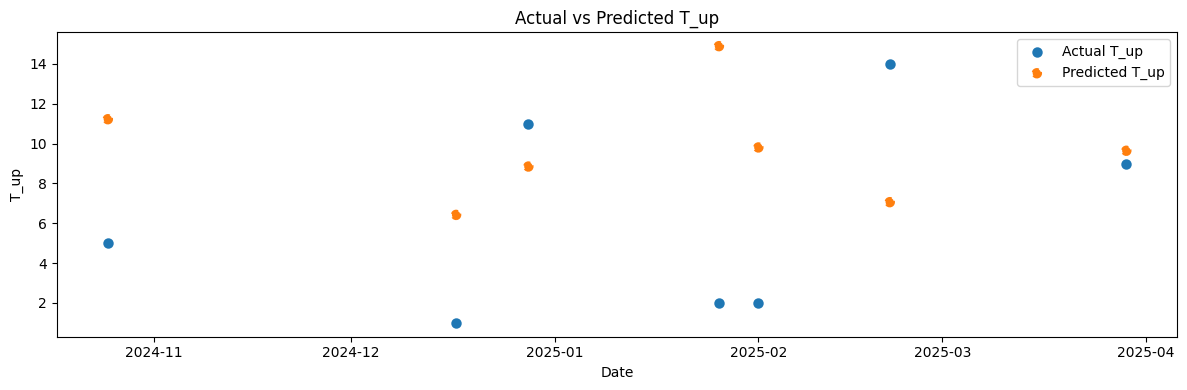

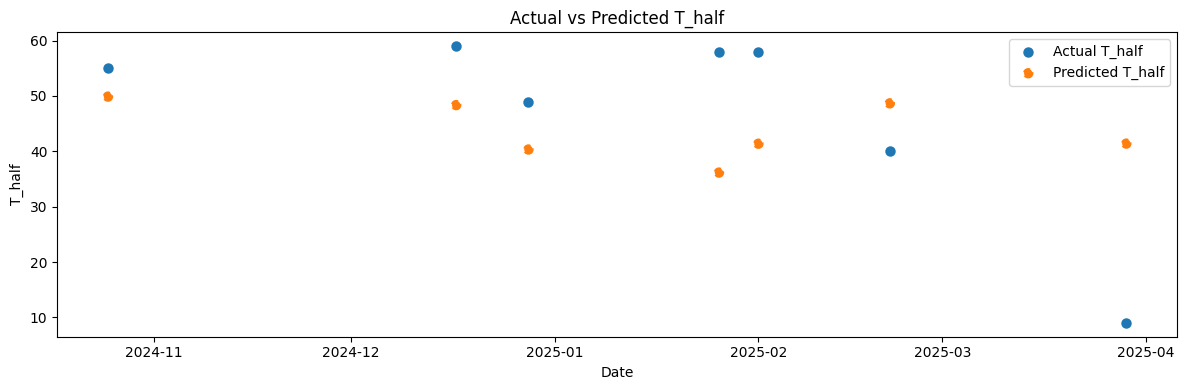

In [1629]:
import joblib, matplotlib.pyplot as plt

feature_cols = arc_df_test.columns.difference(["peak_vix", "T_up", "T_half"])
X_full_test       = arc_df_test[feature_cols].values
dates        = arc_df_test.index         # x‑axis

models = {
    "peak_vix": joblib.load("xgb_peak_vix.pkl"),
    "T_up":     joblib.load("xgb_T_up.pkl"),
    "T_half":   joblib.load("xgb_T_half.pkl"),
}

for target, model in models.items():
    y_true_test = arc_df_test[target].values
    y_pred_test = model.predict(X_full_test)

    plt.figure(figsize=(12, 4))
    plt.scatter(dates, y_true_test, label=f"Actual {target}", linewidth=1.5)
    plt.scatter(dates, y_pred_test, label=f"Predicted {target}", linestyle="--", linewidth=1.5)
    plt.title(f"Actual vs Predicted {target}")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend()
    plt.tight_layout()
    plt.show()


# RECENT/TRADE

In [1630]:
arc_df_test.head()

,peak_vix,vix0,T_up,T_half,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,...,vix_zscore_mean_7d,vix_zscore_std_7d,vix_zscore_pctchg_7d,vix_target_mean_7d,vix_target_std_7d,vix_target_pctchg_7d,sentiment_dominance_mean_7d,sentiment_dominance_std_7d,sentiment_dominance_pctchg_7d,early_spike_prob
date_start,,,,,,,,,,,,,,,,,,,,,
2024-10-25,3.142427,2.985682,5.0,55.0,-0.052174,-0.974781,33.0,0.034727,-0.971487,61.0,...,-0.073980,0.282178,-3.078599,2.930418,0.039978,0.041514,2.750,12.044560,-4.750000,0.5
2024-12-17,3.300000,2.700000,1.0,59.0,-0.200720,-0.973212,95.0,-0.080458,-0.973030,158.0,...,0.009599,0.687173,-5.650664,2.668135,0.049582,0.042460,53.875,19.334924,-0.450000,0.5
2024-12-28,2.972464,2.856470,11.0,49.0,-0.066260,-0.975939,19.0,0.046485,-0.964535,66.0,...,0.226121,0.369535,0.160974,2.765553,0.075801,0.012865,39.375,15.042203,0.138889,0.5
2025-01-26,2.806990,2.884801,2.0,58.0,-0.191643,-0.971789,9.0,-0.085867,-0.854118,15.0,...,-0.735053,0.828896,-1.456885,2.753476,0.081213,0.063700,7.500,15.287717,NaN,0.5
2025-02-01,2.845491,2.924236,2.0,58.0,0.029324,-0.950893,11.0,-0.143875,-0.949542,20.0,...,0.158957,0.637543,0.776365,2.843146,0.058031,0.013670,-1.875,17.216583,0.500000,0.5


In [1464]:
test_df_trade

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat
date,,,,,,,,,,,,,,,,,,,,,
2024-10-16,-0.222685,-0.976018,47,-0.167496,-0.971121,51,40,-0.195090,-0.973569,95,...,0.016615,0.412830,19.328083,2.310096,0.109050,18.521333,18.521333,18.115315,1.097978,0.369787
2024-10-17,-0.224310,-0.974795,34,-0.272826,-0.973557,36,40,-0.248568,-0.974176,78,...,0.011111,0.193659,19.314014,2.234998,-0.091281,18.602667,18.602667,18.146757,1.068928,0.426511
2024-10-18,-0.248795,-0.973813,27,-0.209752,-0.970884,28,22,-0.229274,-0.972349,51,...,-0.120059,-0.260678,19.231174,2.185379,-0.549641,18.652667,18.652667,18.179396,1.041571,0.454381
2024-10-19,0.076486,-0.904173,5,-0.051621,-0.936994,13,4,0.012432,-0.920584,25,...,-0.043727,-0.148076,19.175615,2.124632,-0.379178,18.646000,18.646000,18.209500,1.014136,0.430416
2024-10-20,-0.148248,-0.970708,11,0.232043,-0.928842,25,4,0.041897,-0.949775,43,...,-0.188604,-0.183860,19.123639,2.064789,-0.364995,18.714000,18.714000,18.242048,0.988944,0.477228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-12,-0.089461,-0.957227,43,-0.008691,-0.941981,105,28,-0.049076,-0.949604,195,...,0.426790,0.340215,30.434149,11.581772,0.039359,26.917334,26.917334,29.561233,11.582488,-0.228267
2025-04-13,-0.086733,-0.972444,31,-0.158017,-0.968547,71,34,-0.122375,-0.970495,145,...,0.386445,0.313508,30.463558,11.202517,0.038067,27.125000,27.125000,29.404056,11.219157,-0.203140
2025-04-14,-0.063972,-0.972737,123,-0.219557,-0.973235,208,154,-0.141765,-0.972986,447,...,0.386445,0.283756,30.491071,10.835645,0.036816,27.429000,27.429000,29.276633,10.862432,-0.170094


In [1465]:
def get_past_60_trading_days(df, target_date):
    """
    Given a DataFrame with a DatetimeIndex and a target date (string or datetime),
    return the 60 trading days *before* that date (exclusive).
    """
    # Ensure datetime format
    target_date = pd.to_datetime(target_date)
    
    # Filter to dates strictly before the target date
    df_before = df[df.index < target_date]
    
    # Get last 60 rows before the target date
    return df_before.tail(61)


In [1773]:
df_trade = get_past_60_trading_days(test_df_trade, "2025-01-27")

In [1774]:
df_trade.tail()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat
date,,,,,,,,,,,,,,,,,,,,,
2025-01-22,0.161765,-0.961772,10,-0.063719,-0.946879,27,13,0.049023,-0.954325,57,...,-0.152637,-1.057705,16.614850,2.051680,-0.738346,16.864334,16.864334,16.805059,1.437510,0.041234
2025-01-23,-0.399482,-0.971473,40,-0.107237,-0.972807,36,27,-0.253359,-0.972140,59,...,-0.151412,-1.147747,16.511956,2.024011,-0.737128,16.808334,16.808334,16.805271,1.390366,0.002203
2025-01-24,-0.033728,-0.976062,40,-0.014590,-0.972875,58,36,-0.024159,-0.974469,112,...,-0.240020,-1.262167,16.404733,2.001193,-0.776903,16.833334,16.833334,16.807081,1.344786,0.019522
2025-01-25,0.117867,-0.971038,7,0.201732,-0.680292,15,5,0.159799,-0.825665,28,...,-0.083930,0.623822,16.501202,1.971293,0.709584,16.837334,16.837334,16.809033,1.300704,0.021758
2025-01-26,-0.191643,-0.971789,9,-0.085867,-0.854118,15,6,-0.138755,-0.912954,27,...,-0.067223,0.582292,16.591447,1.938414,0.675064,16.943000,16.943000,16.817676,1.258492,0.099583


In [1775]:
# 1. After fitting on training set
train_params = results.params

# 2. Prepare your test data

X_test = df_trade[selected_features]
y_test = df_trade['vix_ewm_zscore']


In [1776]:
X_test.tail()

,shock_neg,dominance_trigger
date,,
2025-01-22,-0.954325,0
2025-01-23,-0.972140,1
2025-01-24,-0.974469,0
2025-01-25,-0.825665,0
2025-01-26,-0.912954,0


In [1777]:
# 3. Define same model on test data
model_trade = MarkovRegression(
    endog=y_test,
    exog=X_test,
    k_regimes=2
    ,
    switching_variance=False
)

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [1778]:
results_test = model_trade.filter(train_params)

# 5. Extract real-time regime (filtered) — sensitive threshold
df_trade['regime_t_raw'] = results_test.filtered_marginal_probabilities[1]
df_trade['regime_t'] = df_trade['regime_t_raw'].apply(lambda r: 1 if r > percentile_markov else 0)

# 6. Predict probability of panic regime tomorrow using classifier (NO regime_t)
df_trade['panic_prob_t+1'] = clf.predict_proba(X_test)[:, 1]

In [1779]:
df_trade.tail()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,ewm_std,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat,regime_t_raw,regime_t,panic_prob_t+1
date,,,,,,,,,,,,,,,,,,,,,
2025-01-22,0.161765,-0.961772,10,-0.063719,-0.946879,27,13,0.049023,-0.954325,57,...,2.051680,-0.738346,16.864334,16.864334,16.805059,1.437510,0.041234,0.000964,0,0.462583
2025-01-23,-0.399482,-0.971473,40,-0.107237,-0.972807,36,27,-0.253359,-0.972140,59,...,2.024011,-0.737128,16.808334,16.808334,16.805271,1.390366,0.002203,0.000506,0,0.252226
2025-01-24,-0.033728,-0.976062,40,-0.014590,-0.972875,58,36,-0.024159,-0.974469,112,...,2.001193,-0.776903,16.833334,16.833334,16.807081,1.344786,0.019522,0.000794,0,0.353653
2025-01-25,0.117867,-0.971038,7,0.201732,-0.680292,15,5,0.159799,-0.825665,28,...,1.971293,0.709584,16.837334,16.837334,16.809033,1.300704,0.021758,0.399726,0,0.373847
2025-01-26,-0.191643,-0.971789,9,-0.085867,-0.854118,15,6,-0.138755,-0.912954,27,...,1.938414,0.675064,16.943000,16.943000,16.817676,1.258492,0.099583,0.938072,1,0.467093


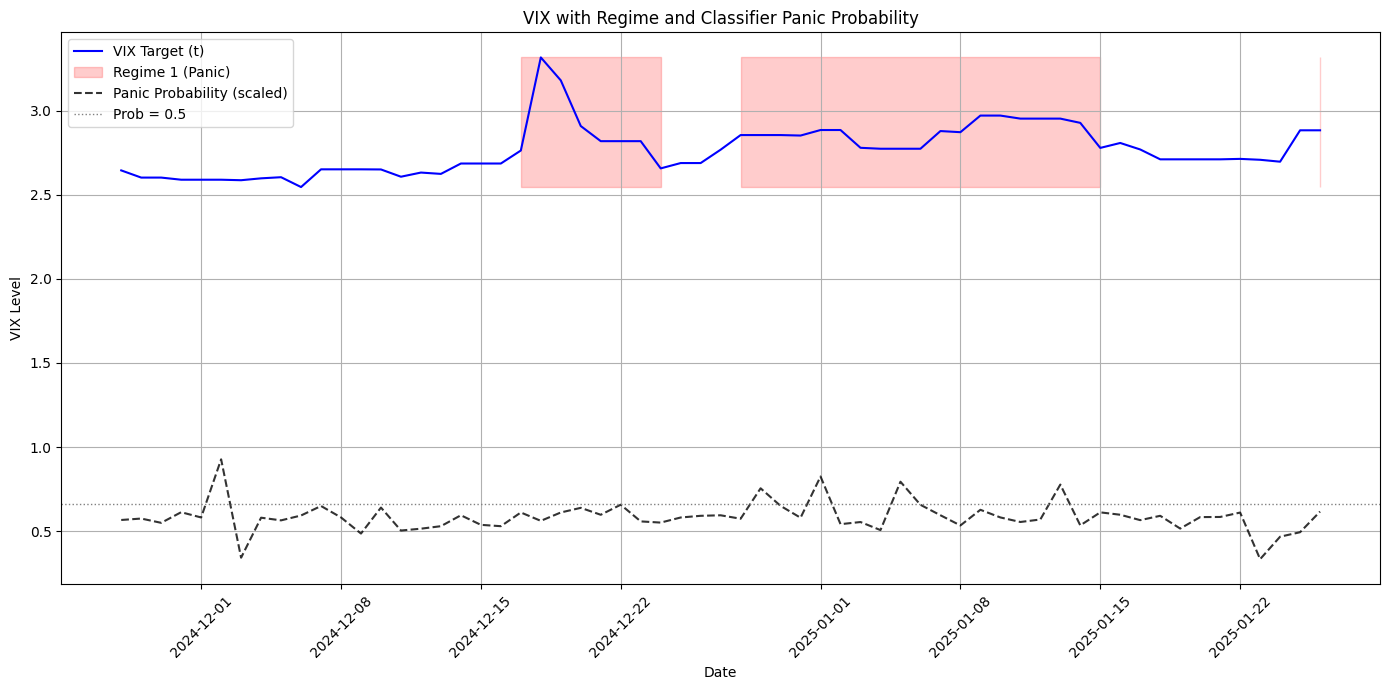

In [1780]:
import matplotlib.pyplot as plt

# Assumes test_df already has:
# - 'vix_target_t+1' (VIX values)
# - 'regime_t' (real-time inferred regime: 0 or 1)
# - 'panic_prob_t+1' (classifier probability of panic tomorrow)

plt.figure(figsize=(14, 7))

# 1. Plot VIX
plt.plot(df_trade.index, df_trade["vix_target"], label="VIX Target (t)", color="blue")

# 2. Shade areas where regime is 1 (panic)
plt.fill_between(
    df_trade.index,
    df_trade["vix_target"].min(),
    df_trade["vix_target"].max(),
    where=df_trade["regime_t"] == 1,
    color="red",
    alpha=0.2,
    label="Regime 1 (Panic)"
)

# 3. Plot panic probability (scaled for visibility)
scaled_prob = df_trade["panic_prob_t+1"] * (df_trade["vix_target"].max() - 2)
plt.plot(df_trade.index, scaled_prob, label="Panic Probability (scaled)", color="black", linestyle="--", alpha=0.8)

# Optional: Add threshold line for prob=0.5 scaled to same scale
plt.axhline(y=0.5 * (df_trade["vix_target"].max() - 2), color="gray", linestyle=":", linewidth=1, label="Prob = 0.5")

# Finalize
plt.title("VIX with Regime and Classifier Panic Probability")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [1781]:
classification_df_trade = macro_utils.identify_sustained_regimes_and_transitions(df_trade, trade = True)

In [1782]:
classification_df_trade.shape

(61, 33)

In [1783]:
result_trade = macro_utils.transform_vix_data(classification_df_trade, window=50, trade = True, k=2)
vix_windows_past_df_trade = result_trade["vix_windows_past_df_train"]

In [1784]:
vix_windows_past_df_trade

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 41,Day 42,Day 43,Day 44,Day 45,Day 46,Day 47,Day 48,Day 49,Day 50
transition_time,,,,,,,,,,,,,,,,,,,,,
2025-01-26,2.652537,2.652537,2.652537,2.651833,2.608598,2.633327,2.625393,2.687167,2.687167,2.687167,...,2.809403,2.770712,2.712042,2.712042,2.712042,2.712042,2.714695,2.709383,2.698,2.884801


In [1785]:
from macro_utils import calculate_pct_changes

# Get current date (your live transition point — usually last row in trade DF)
live_index = classification_df_trade[classification_df_trade["is_transition"]].index[-1:]
print(f"✅ Using live index: {live_index}")

# Calculate past % changes from historical VIX column
vix_pct_change_lookback_df_trade, used_indices = calculate_pct_changes(
    df_model=classification_df_trade,
    valid_indices=live_index,
    lookback=30,
    vix_column="vix_target"
)

# Now predict with  classifier
early_spike_prob_trade = clf_delayed_spike_prob.predict_proba(vix_pct_change_lookback_df_trade)[0][1]
print(f"🟢 Early spike probability: {early_spike_prob_trade:.2%}")


✅ Using live index: DatetimeIndex(['2025-01-26'], dtype='datetime64[ns]', name='date', freq=None)
🟢 Early spike probability: 57.75%


In [1786]:
vix_pct_change_lookback_df_trade.head()

,Day -30,Day -29,Day -28,Day -27,Day -26,Day -25,Day -24,Day -23,Day -22,Day -21,...,Day -10,Day -9,Day -8,Day -7,Day -6,Day -5,Day -4,Day -3,Day -2,Day -1
2025-01-26,0.029582,0.031418,0.0,0.0,-0.001007,0.011523,0.0,-0.036652,-0.002012,0.0,...,0.010554,-0.013772,-0.021175,0.0,0.0,0.0,0.000978,-0.001957,-0.004201,0.069237


In [1816]:
# =============================================================
# 0)  PREP  –  make sure the raw news DataFrame is date‑indexed
# =============================================================
news_test = df_trade.copy()                       # original df you posted   # string/ts column → index
news_test = news_test.sort_index()                     # chronological order

# =============================================================
# 1)  ENGINEER EXTRA NEWS FEATURES (text‑only)
# =============================================================
def engineer_news_feats(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # --- positive / negative ratios and range (max‑min) ---
    for prefix in ['summary', 'headline', 'overall']:
        neg = f'{prefix}_neg_count'
        tot = f'{prefix}_tot_count'

    # --- one‑hot encode sentiment dominance flag -------------
    dom_dummies = pd.get_dummies(out['dominance_trigger'], prefix='dom')
    out = pd.concat([out, dom_dummies], axis=1)

    # OPTIONAL: drop the raw *_tot_count columns
    out = out.drop(columns=[c for c in out.columns if c.endswith('_tot_count')])
    return out

news_feats_trade = engineer_news_feats(news_test)

# =============================================================
# 2)  DENSE DAILY INDEX  (forward‑fill missing dates)
# =============================================================
news_feats_trade.index = pd.to_datetime(news_feats_trade.index).normalize()        # 00:00:00
dense_idx = pd.date_range(news_feats_trade.index.min(),
                          news_feats_trade.index.max(),
                          freq='D')

news_dense_trade = (
    news_feats_test
      .reindex(dense_idx)      # insert weekends / holidays
      .ffill()                 # carry last known sentiment forward
)

In [1817]:
news_dense_trade.columns

Index(['summary_mean', 'summary_min', 'summary_neg_count', 'headline_mean',
       'headline_min', 'headline_pos_count', 'headline_neg_count',
       'overall_mean', 'overall_min', 'overall_pos_count', 'overall_neg_count',
       'vix_target', 'mean_sentiment_decay', 'shock_neg',
       'sentiment_dominance', 'dominance_trigger', 'vix_7d_pct', 'vix_zscore',
       'ewm_mean', 'ewm_std', 'vix_ewm_zscore', 'mean_prev', 'vix_flat_abs',
       'ewm_mean_flat', 'ewm_std_flat', 'vix_ewm_zscore_flat', 'regime_t_raw',
       'regime_t', 'panic_prob_t+1', 'vix_target_t+1', 'regime_group',
       'is_sustained_regime1', 'regime_t-1', 'is_transition', 'dom_0',
       'dom_1'],
      dtype='object')

In [1818]:
feature_cols = feature_cols.drop(['date','date.1'], errors='ignore')


In [1819]:
df_trade.columns

Index(['summary_mean', 'summary_min', 'summary_neg_count', 'headline_mean',
       'headline_min', 'headline_pos_count', 'headline_neg_count',
       'overall_mean', 'overall_min', 'overall_pos_count', 'overall_neg_count',
       'vix_target', 'mean_sentiment_decay', 'shock_neg',
       'sentiment_dominance', 'dominance_trigger', 'vix_7d_pct', 'vix_zscore',
       'ewm_mean', 'ewm_std', 'vix_ewm_zscore', 'mean_prev', 'vix_flat_abs',
       'ewm_mean_flat', 'ewm_std_flat', 'vix_ewm_zscore_flat', 'regime_t_raw',
       'regime_t', 'panic_prob_t+1', 'regime_group', 'is_sustained_regime1',
       'regime_t-1', 'is_transition'],
      dtype='object')

In [1820]:
def build_live_arc_row(start_idx,
                       news_dense,
                       classification_df_trade,
                       feature_cols,
                       lookback_days=(2, 5, 7),
                       lookback_feats=("shock_neg", "vix_zscore", "vix_target", "sentiment_dominance")):
    """
    Build one live-arc row of features at timestamp `start_idx`.
    Returns a DataFrame with one row and columns exactly = feature_cols.
    """
    # normalize the timestamp
    dt_norm = pd.to_datetime(start_idx).normalize()

    # --- 1) grab the base row from classification_df_trade ---
    try:
        row = classification_df_trade.loc[[start_idx]].copy()
    except KeyError:
        print(f"❌ No classification data at {start_idx}")
        return None

    # --- 2) pull the latest news features (dropping any 'date' col) ---
    try:
        feats_on_start = (
            news_dense
            .loc[:dt_norm]
            .iloc[-1]
            .drop(labels=["date"], errors="ignore")
            .to_dict()
        )
    except IndexError:
        print(f"❌ No prior news available at {dt_norm}")
        return None

    # --- 3) one-hot encode the 'dominance_trigger' field ---
    dom_dummies = pd.get_dummies(row["dominance_trigger"], prefix="dom")
    # ensure both dom_0 and dom_1 exist
    for col in ("dom_0", "dom_1"):
        dom_dummies[col] = dom_dummies.get(col, 0)
    row = pd.concat([row, dom_dummies], axis=1)

    # --- 4) merge in the news features ---
    row = row.assign(**feats_on_start)

    # --- 5) drop any raw date columns to avoid leakage ---
    row = row.drop(columns=[c for c in row.columns if c.startswith("date")], errors="ignore")

    # --- 6) compute look-back stats for each window & feature ---
    lookback_stats = {}
    for w in lookback_days:
        start_date = dt_norm - pd.Timedelta(days=w)
        window_df = classification_df_trade.loc[start_date:dt_norm]

        for feat in lookback_feats:
            series = window_df.get(feat, pd.Series(dtype=float))
            m = series.mean()
            s = series.std()
            if len(series) > 1 and series.iloc[0] != 0:
                pct = (series.iloc[-1] - series.iloc[0]) / series.iloc[0]
            else:
                pct = np.nan

            lookback_stats[f"{feat}_mean_{w}d"]   = m
            lookback_stats[f"{feat}_std_{w}d"]    = s
            lookback_stats[f"{feat}_pctchg_{w}d"] = pct

    # merge lookback stats into row
    row = row.assign(**lookback_stats)

    # --- 7) finally, extract exactly the requested feature_cols (filling missing with 0) ---
    feature_values = {
        col: row[col].iloc[0] if col in row.columns else 0.0
        for col in feature_cols
    }
    arc_row = pd.DataFrame([feature_values], index=[start_idx])[feature_cols]
    return arc_row


In [1821]:
start_idx = classification_df_trade[classification_df_trade["is_transition"]].index[-1]

# Build feature row
arc_row_live = build_live_arc_row(start_idx, news_dense_trade, classification_df_trade, feature_cols)


In [1822]:
arc_row_live['early_spike_prob'] = early_spike_prob_trade

In [1823]:
print(early_spike_prob_trade)

0.5775


In [1824]:
if early_spike_prob_trade > 0.75:
    min_vix=df_trade['vix_target'].iloc[-20:].min()
    arc_row_live['vix0'] = min_vix
    print('<')
    print(min_vix)
else:
    min_vix=df_trade['vix_target'].iloc[-1:].min()
    arc_row_live['vix0'] = min_vix
    print(min_vix)


2.8848006915355513


In [1825]:
print(arc_row_live['vix0'])

2025-01-26    2.884801
Name: vix0, dtype: float64


In [1826]:
arc_row_live.columns

Index(['dom_0', 'dom_1', 'dominance_trigger', 'early_spike_prob', 'ewm_mean',
       'ewm_mean_flat', 'ewm_std', 'ewm_std_flat', 'headline_mean',
       'headline_min', 'headline_neg_count', 'headline_pos_count', 'mean_prev',
       'mean_sentiment_decay', 'overall_mean', 'overall_min',
       'overall_neg_count', 'overall_pos_count', 'sentiment_dominance',
       'sentiment_dominance_mean_2d', 'sentiment_dominance_mean_5d',
       'sentiment_dominance_mean_7d', 'sentiment_dominance_pctchg_2d',
       'sentiment_dominance_pctchg_5d', 'sentiment_dominance_pctchg_7d',
       'sentiment_dominance_std_2d', 'sentiment_dominance_std_5d',
       'sentiment_dominance_std_7d', 'shock_neg', 'shock_neg_mean_2d',
       'shock_neg_mean_5d', 'shock_neg_mean_7d', 'shock_neg_pctchg_2d',
       'shock_neg_pctchg_5d', 'shock_neg_pctchg_7d', 'shock_neg_std_2d',
       'shock_neg_std_5d', 'shock_neg_std_7d', 'summary_mean', 'summary_min',
       'summary_neg_count', 'vix0', 'vix_7d_pct', 'vix_ewm_zscore'

In [1827]:
import joblib
import pandas as pd

models = {
    "peak_vix": joblib.load("mlp_peak_vix.pkl"),
    "T_up":     joblib.load("mlp_T_up.pkl"),
    "T_half":   joblib.load("mlp_T_half.pkl"),
}


In [1828]:
print(list(feature_cols))
print(list(arc_df_test.columns))
print(list(arc_row_live.columns))

['dom_0', 'dom_1', 'dominance_trigger', 'early_spike_prob', 'ewm_mean', 'ewm_mean_flat', 'ewm_std', 'ewm_std_flat', 'headline_mean', 'headline_min', 'headline_neg_count', 'headline_pos_count', 'mean_prev', 'mean_sentiment_decay', 'overall_mean', 'overall_min', 'overall_neg_count', 'overall_pos_count', 'sentiment_dominance', 'sentiment_dominance_mean_2d', 'sentiment_dominance_mean_5d', 'sentiment_dominance_mean_7d', 'sentiment_dominance_pctchg_2d', 'sentiment_dominance_pctchg_5d', 'sentiment_dominance_pctchg_7d', 'sentiment_dominance_std_2d', 'sentiment_dominance_std_5d', 'sentiment_dominance_std_7d', 'shock_neg', 'shock_neg_mean_2d', 'shock_neg_mean_5d', 'shock_neg_mean_7d', 'shock_neg_pctchg_2d', 'shock_neg_pctchg_5d', 'shock_neg_pctchg_7d', 'shock_neg_std_2d', 'shock_neg_std_5d', 'shock_neg_std_7d', 'summary_mean', 'summary_min', 'summary_neg_count', 'vix0', 'vix_7d_pct', 'vix_ewm_zscore', 'vix_ewm_zscore_flat', 'vix_flat_abs', 'vix_target_mean_2d', 'vix_target_mean_5d', 'vix_target_

In [1829]:
feature_cols = arc_df_test.columns.difference(["peak_vix", "T_up", "T_half"])

In [1830]:
arc_row_live = arc_row_live.reindex(columns=feature_cols)

In [1831]:
arc_row_live['vix0']

2025-01-26    2.884801
Name: vix0, dtype: float64

In [1832]:
arc_row_live['early_spike_prob'] = early_spike_prob_trade

In [1833]:
print(early_spike_prob_trade)

0.5775


In [1834]:
arc_row_live

,dom_0,dom_1,dominance_trigger,early_spike_prob,ewm_mean,ewm_mean_flat,ewm_std,ewm_std_flat,headline_mean,headline_min,...,vix_zscore,vix_zscore_mean_2d,vix_zscore_mean_5d,vix_zscore_mean_7d,vix_zscore_pctchg_2d,vix_zscore_pctchg_5d,vix_zscore_pctchg_7d,vix_zscore_std_2d,vix_zscore_std_5d,vix_zscore_std_7d
2025-01-26,True,False,0,0.5775,16.591447,16.817676,1.938414,1.258492,-0.085867,-0.854118,...,0.582292,-0.018684,-0.566929,-0.735053,-1.461343,-1.510753,-1.456885,1.077088,0.908697,0.828896


In [1837]:
arc_row_live.isna().sum()[arc_row_live.isna().sum() > 0]


Series([], dtype: int64)

In [1836]:
arc_row_live['sentiment_dominance_pctchg_7d'] = arc_row_live['sentiment_dominance_pctchg_5d']

In [1838]:
print(arc_row_live['vix0'])


2025-01-26    2.884801
Name: vix0, dtype: float64


In [1839]:
X_full_test.iloc[1].equals(arc_row_live)


False

In [1840]:

# Predict
if arc_row_live is not None:
    live_preds = {
        target: float(models[target].predict(arc_row_live[feature_cols].values))
        for target in models
    }

    print(f"\n📍 Live prediction at {start_idx.date()}:")
    for target, val in live_preds.items():
        print(f"  {target:<8} → {val:.2f}")
else:
    print("❌ Failed to build input row.")



📍 Live prediction at 2025-01-26:
  peak_vix → 2.98
  T_up     → 5.38
  T_half   → 56.49


/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_72581/2082501707.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  target: float(models[target].predict(arc_row_live[feature_cols].values))
/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_72581/2082501707.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  target: float(models[target].predict(arc_row_live[feature_cols].values))
/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_72581/2082501707.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array 

In [1740]:
print(np.exp(2.95))

19.10595372823165


# XGB prediction

In [1423]:
import joblib
import pandas as pd

xgb_models = {
    "peak_vix": joblib.load("xgb_peak_vix.pkl"),
    "T_up":     joblib.load("xgb_T_up.pkl"),
    "T_half":   joblib.load("xgb_T_half.pkl"),
}


In [1424]:

# Predict
if arc_row_live is not None:
    live_preds = {
        target: float(xgb_models[target].predict(arc_row_live[feature_cols].values))
        for target in xgb_models
    }

    print(f"\n📍 Live prediction at {start_idx.date()}:")
    for target, val in live_preds.items():
        print(f"  {target:<8} → {val:.2f}")
else:
    print("❌ Failed to build input row.")



📍 Live prediction at 2024-12-17:
  peak_vix → 3.24
  T_up     → 9.86
  T_half   → 48.93


/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_72581/4101907363.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  target: float(xgb_models[target].predict(arc_row_live[feature_cols].values))
/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_72581/4101907363.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  target: float(xgb_models[target].predict(arc_row_live[feature_cols].values))
/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_72581/4101907363.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from you